# <font color='#002726'> Data Science em Produção </font>
    
=-=- ROSSMANN - STORE SALES PREDICTION -=-=

# <font color='#3F0094'> 0. Imports </font>

In [1]:
# general use
import numpy as np
import pandas as pd

# helper function
import inflection

# feature engineering and data analysis
import seaborn as sns
from matplotlib                    import gridspec, pyplot as plt
from IPython.display               import Image
from scipy.stats                   import ranksums, chi2_contingency
from datetime                      import datetime, timedelta
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

# data preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# feature selection
from boruta           import BorutaPy

# machine learning
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble     import RandomForestRegressor 
from sklearn.metrics      import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## <font color='#200CF'> 0.1. Helper Functions </font>

In [80]:
# Notebook Setups

sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Set2')

# Functions

def snakecase(list_of_names):
    """Returns a list of names in snake case, which refers to the style of  
    writing in which each space is replaced by an underscore (_) character."""
    
    new_list = list(map(inflection.underscore, list_of_names))
    return new_list


def bootstrap(attribute, estimate='mean', n_repeat=100, n_sample=100, ci=95):
    """Bootstrap"""
    
    results = []
    
    if estimate == 'mean':
        for n in range(n_repeat):
            sample = np.random.choice(a=attribute, size=n_sample)
            results.append(np.mean(sample))
    elif estimate == 'median':
        for n in range(n_repeat):
            sample = np.random.choice(a=attribute, size=n_sample)
            results.append(np.median(sample))
    else:
        results = [0]
    
    ci_bottom = (100 - ci) / 2
    ci_top = ci + (100 - ci) / 2
    
    statistic_mean = np.mean(results)
    statistic_std_error = np.std(results)
    lower_percentile = np.percentile(results, q=ci_bottom)
    upper_percentile = np.percentile(results, q=ci_top)
    
    return [statistic_mean, statistic_std_error, lower_percentile, upper_percentile]


def cramer_v(x, y):
    """Cramér's V formula to measure the association between two nominal variables"""
    
    # confusion matrix - getting the values only (as matrix)
    cm = pd.crosstab(x, y).values
    # chi2_contingency from scipy returns a list, the first value is the statistic test result
    chi2 = chi2_contingency(cm)[0]
    # n is the grand total of observations
    n = cm.sum()
    # number of rows and columns
    r, k = cm.shape
    
    # bias correction 
    phi_cor = max(0, chi2/n - (k-1)*(r-1)/(n-1))
    k_cor = k - (k-1)**2/(n-1)
    r_cor = r - (r-1)**2/(n-1)

    return np.sqrt((phi_cor) / (min(k_cor-1, r_cor-1)))


def ml_error(model_name, y, yhat):
    """Tests machine learning model prediction error."""
    
    # mean absolute error (MAE)
    mae = mean_absolute_error(y , yhat)
    
    # mean absolute percentage error (MAPE)
    mape = mean_absolute_percentage_error(y, yhat)
    
    # root-mean-square error (RMSE)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae, 
                         'MAPE': mape, 
                         'RMSE': rmse}, index=[0])


def cross_validation(X_train, kfold, model_name, ml_model, verbose=False):
    
    # lists to keep the error results
    mae_list, mape_list, rmse_list = [], [], []

    # cross validation folds
    for k in range(kfold, 0, -1):
        
        # checking if verbose is true
        if verbose:
            print(f'\nKFold Number: {k}')
        
        # start date and end date of validation
        validation_start_date = X_train['date'].max() - timedelta(days=k*6*7)
        validation_end_date = X_train['date'].max() - timedelta(days=(k-1)*6*7)

        # splitting into traning and validation
        training   = X_train[X_train['date'] < validation_start_date]
        validation = X_train[(X_train['date'] >= validation_start_date) & (X_train['date'] <= validation_end_date)]

        # preparing training and validation datasets - removing response subsets
        # training
        y_training = training['sales']
        x_training_ml = training.drop(['date', 'sales'], axis=1)
        # validation
        y_validation = validation['sales']
        x_validation_ml = validation.drop(['date', 'sales'], axis=1)

        # model
        model_fit = ml_model.fit(x_training_ml, y_training)
        # predicition
        yhat = model_fit.predict(x_validation_ml)
        # performance
        result = ml_error(model_name, np.expm1(y_validation), np.expm1(yhat))

        # appending error values to the lists in each iteration of KFold
        mae_list.append(result['MAE'][0])
        mape_list.append(result['MAPE'][0])
        rmse_list.append(result['RMSE'][0])

    # returning a dataframe with mean and std of each error measure
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round((np.std(mae_list)), 2).astype(str), 
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round((np.std(mape_list)), 2).astype(str), 
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round((np.std(rmse_list)), 2).astype(str), 
    }, index=[0])



## <font color='#200CF'> 0.2. Loading Data </font>

In [3]:
# loading historical data - including Sales
df_sales_raw = pd.read_csv('../raw_data/train.csv', low_memory=False)

# loading information about the stores
df_store_raw = pd.read_csv('../raw_data/store.csv', low_memory=False)

# merging dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### <font color='#F37126'> Data Fields </font>

**Most of the fields are self-explanatory. The following are descriptions for those that aren't.**

- **Id** - an Id that represents a (Store, Date) duple within the test set;
- **Store** - a unique Id for each store;
- **Sales** - the turnover for any given day (this is what you are predicting);
- **Customers** - the number of customers on a given day;
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open;
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None;
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools;
- **StoreType** - differentiates between 4 different store models: a, b, c, d;
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended;
- **CompetitionDistance** - distance in meters to the nearest competitor store;
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened;
- **Promo** - indicates whether a store is running a promo on that day;
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating;
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2;
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# <font color='#3F0094'> 1. Descriptive Data Analysis </font>

## <font color='#200CF'> 1.0. Dataframe in Progress Backup </font>

In [4]:
df1 = df_raw.copy()

## <font color='#200CF'> 1.1. Column Renaming </font>

In [5]:
# renaming df1 column names
df1.columns = snakecase(df1.columns)


## <font color='#200CF'> 1.2. Data Dimension </font>

In [6]:
print(f'Store Dataframe - Number of Rows: {df1.shape[0]}. \nStore Dataframe - Number of Columns: {df1.shape[1]}.')

Store Dataframe - Number of Rows: 1017209. 
Store Dataframe - Number of Columns: 18.


## <font color='#200CF'> 1.3. Data Types </font>

In [7]:
# dataframe data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
# setting date column as datetime type
df1['date'] = pd.to_datetime(df1['date'])


## <font color='#200CF'> 1.4. NA Check </font>

In [9]:
# checking NA - All NA values came from store.csv
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
# checking NA using info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## <font color='#200CF'> 1.5. Filling in Missing/Null Values </font>

**Number of NA Values**

    competition_distance              2642

    competition_open_since_month    323348
    competition_open_since_year     323348

    promo2_since_week               508031
    promo2_since_year               508031
    promo_interval                  508031

In [11]:
# competition_distance

# maximun distance x 2
max_dist_x_2 = df1['competition_distance'].max() * 2

# assuming competitors are twice as far away as the greatest distance found
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_dist_x_2 if np.isnan(x) else x)


# competition_open_since_year

# frequency per year of existing competition_open_since_year data
frequency = df1['competition_open_since_year'].value_counts(
                                                normalize=True).reset_index().rename(
                                                columns={'index': 'year', 
                                                         'competition_open_since_year': 'percent'})

# True/False missing/Null Series
missing = df1['competition_open_since_year'].isna()

# Using Numpy's random.choice to fill out missing data based on the frequency of existing info
df1.loc[missing,'competition_open_since_year'] = np.random.choice(frequency.year, 
                                                                  size=len(df1[missing]), 
                                                                  p=frequency.percent)


# competition_open_since_month

# frequency per month of existing competition_open_since_month data
frequency = df1['competition_open_since_month'].value_counts(
                                                normalize=True).reset_index().rename(
                                                columns={'index': 'month', 
                                                         'competition_open_since_month': 'percent'})

# True/False missing/Null Series
missing = df1['competition_open_since_month'].isna()

# Using Numpy's random.choice to fill out missing data based on the frequency of existing info
df1.loc[missing,'competition_open_since_month'] = np.random.choice(frequency.month, 
                                                                   size=len(df1[missing]), 
                                                                   p=frequency.percent)

# promo2_since_week AND promo2_since_year

# the same date of sale will be used as a reference to fill in the NA values
# then a new timedelta column will be created (promo2_duration)

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval

# filling in NA with 'none'
df1['promo_interval'].fillna(value='none', inplace=True)
# creating a column with current month
df1['curr_month'] = df1['date'].dt.strftime('%b')
# creating a column to indicate whether promo2 is active
df1['promo2_active'] = df1.apply(lambda x: 1 if ((
    x['curr_month'] in x['promo_interval'].split(',')) and (
    x['date'] >= datetime.fromisocalendar(int(x['promo2_since_year']), int(x['promo2_since_week']), 1)) and (
    x['promo'] == 1)) else 0, axis=1)

## <font color='#200CF'> 1.6. Changing Data Types </font>

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
curr_month                              object
promo2_active                            int64
dtype: object

In [13]:
# Changing DTypes from float to integer

df1['competition_distance'] = df1['competition_distance'].astype(int)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## <font color='#200CF'> 1.7. Descriptive Statistics </font>

### <font color='#2365FF'> 1.7.0. Numeric vs Categorical - Attributes Split </font>

In [14]:
# dataframe - numeric attributes
df_numeric = df1.select_dtypes(include=['int64', 'float64'])

# dataframe - categorical attributes
df_categorical = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### <font color='#2365FF'> 1.7.1. Numeric Attributes </font>

In [15]:
# using DF describe() method
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5810.044888,10715.012901,20.0,710.0,2330.0,6910.0,151720.0
competition_open_since_month,1017209.0,7.218612,3.212896,1.0,4.0,8.0,10.0,12.0
competition_open_since_year,1017209.0,2008.686515,6.025445,1900.0,2006.0,2010.0,2013.0,2015.0


In [16]:
# central tendency metrics - mean, median
ct_mean = df_numeric.apply(np.mean)
ct_median = df_numeric.apply(np.median)

# dispersion metrics - std, min, max, range, skew, kurtosis
d_std = df_numeric.apply(np.std)
d_min = df_numeric.apply(min)
d_max = df_numeric.apply(max)
d_range = df_numeric.apply(lambda x: x.max() - x.min())
d_skew = df_numeric.apply(lambda x: x.skew())
d_kurtosis = df_numeric.apply(lambda x: x.kurtosis())

metrics = pd.DataFrame({
    'min': d_min, 'max': d_max, 'range': d_range, 'mean': ct_mean, 
    'median': ct_median, 'std': d_std, 'skew': d_skew, 'kurtosis': d_kurtosis
})
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1,1115,1114,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1,7,6,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0,41551,41551,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0,7388,7388,633.145946,609.0,464.411506,1.598650,7.091773
open,0,1,1,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0,1,1,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0,1,1,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20,151720,151700,5810.044888,2330.0,10715.007635,7.593832,90.447876
competition_open_since_month,1,12,11,7.218612,8.0,3.212895,-0.167168,-1.250464
competition_open_since_year,1900,2015,115,2008.686515,2010.0,6.025442,-7.606072,122.637469


**competition_distance**
 - Skew: highly skewed data, high positive value means that the right-hand tail is much longer than the left-hand tail.
 - Kurtosis: increases as the tails become heavier, the high positive value indicates a very peaked curve.

**competition_open_since_year**
 - Skew: highly skewed data, high negative value means that the left-hand tail is longer than the right-hand tail.
 - Kurtosis: increases as the tails become heavier, the high positive value indicates a very peaked curve.

**sales**
 - Skewness is close to zero, indicating that the data is not too skewed

### <font color='#2365FF'> 1.7.2. Categorical Attributes </font>

In [17]:
# verifying unique valuesfor each categorical attribute
df_categorical.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
curr_month        12
dtype: int64

**BOXPLOT OF CATEGORICAL ATTRIBUTES**

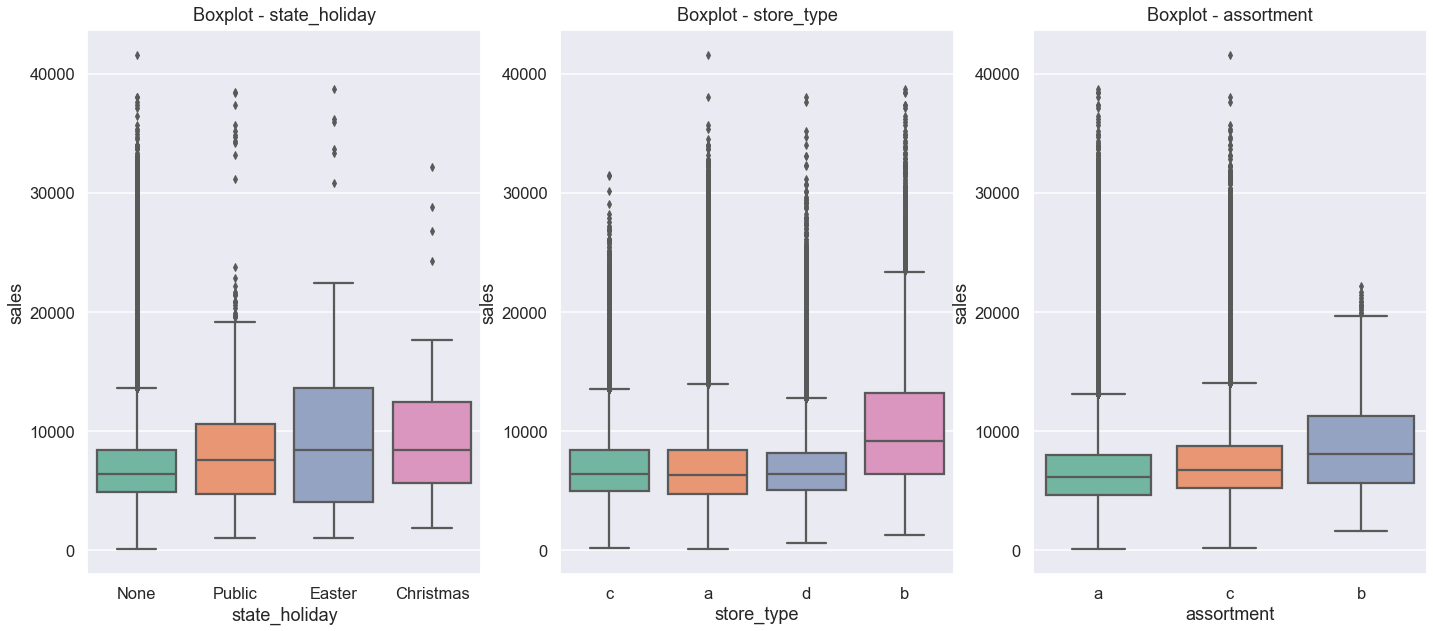

In [18]:
# Boxplot - Categorical Attributes

# not considering when: sales = 0 
aux = df1[df1['sales'] > 0]

plt.figure(figsize=(24,10))

plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=aux)
ax1.set_title('Boxplot - state_holiday', fontsize=18, pad=10)
ax1.set_xticklabels(labels=['None', 'Public', 'Easter', 'Christmas'])

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=aux)
ax2.set_title('Boxplot - store_type', fontsize=18, pad=10)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=aux)
ax3.set_title('Boxplot - assortment', fontsize=18, pad=10)

plt.show()

**BOXPLOT OF BINARY CATEGORICAL ATTRIBUTES**

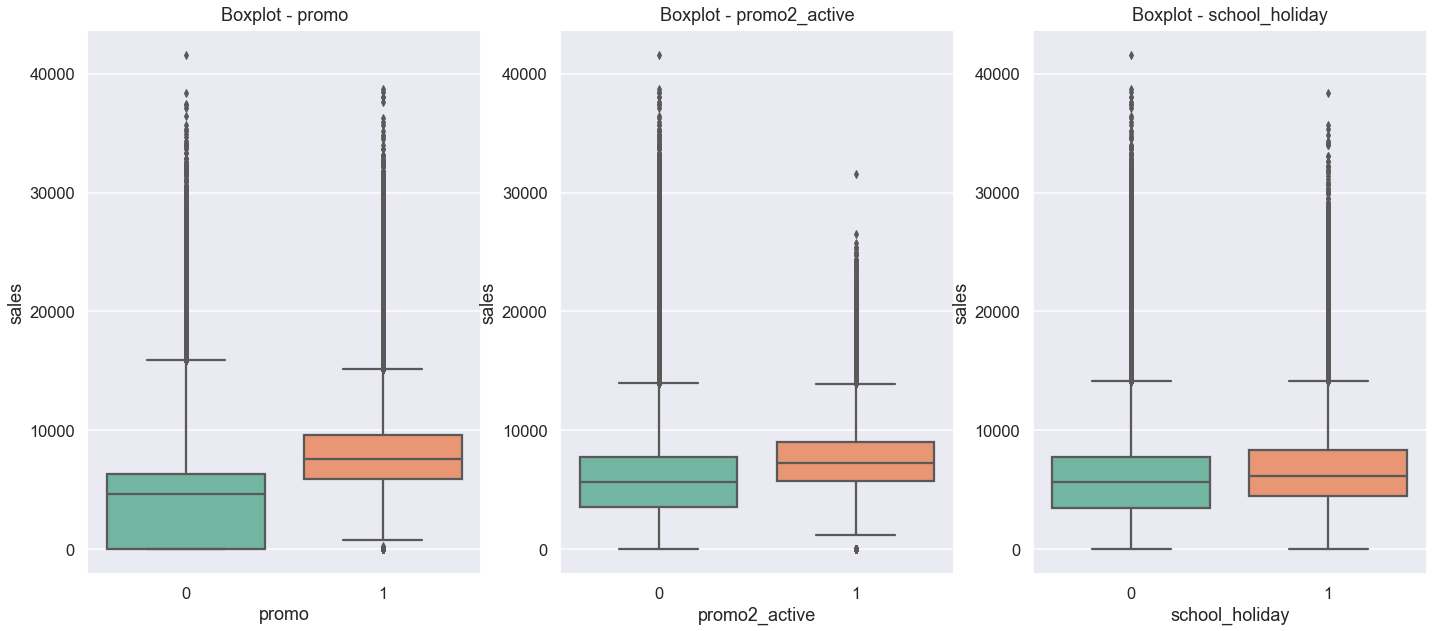

In [19]:
# Boxplot - Binary ategorical Attributes

plt.figure(figsize=(24,10))

plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='promo', y='sales', data=df1)
ax1.set_title('Boxplot - promo', fontsize=18, pad=10)

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='promo2_active', y='sales', data=df1)
ax2.set_title('Boxplot - promo2_active', fontsize=18, pad=10)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='school_holiday', y='sales', data=df1)
ax3.set_title('Boxplot - school_holiday', fontsize=18, pad=10)

plt.show()

# <font color='#3F0094'> 2. Feature Egineering </font>

## <font color='#200CF'> 2.0. Dataframe in Progress Backup </font>

In [20]:
df2 = df1.copy()

## <font color='#200CF'> 2.1. Mind Map </font>

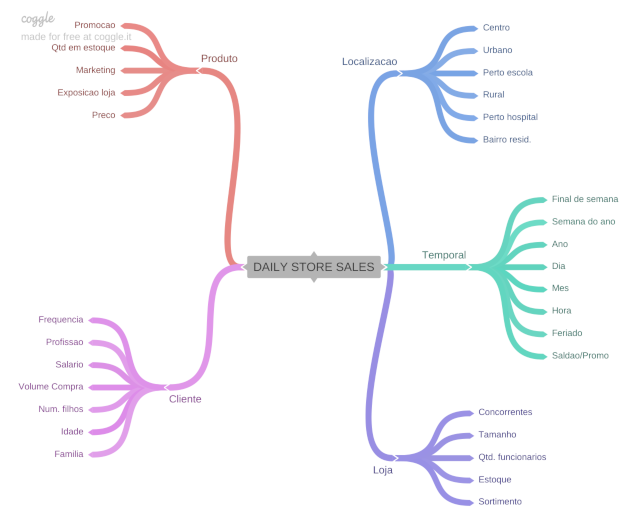

In [21]:
# made on coggle.it
Image('../img/mind_map01.png')

## <font color='#200CF'> 2.2. Hypothesis </font>

**Based on Descriptive Statistics and on Mind Map**

### <font color='#2365FF'> 2.2.1. Store-related Hypothesis </font>


**H1.** The larger the assortment the greater the global sales of the stores should be.

**H2.** The median sales of stores with the largest assortment should be the highest.

**H3.** The volume of sales varies according to the type of the store.

**H4.** The average value of sales for a specific type of store is higher than the average value for other types (store types: a, b, c, d).

**H5.** The sales revenue of stores are lower the closer the competitors are located.

**H6.** The average sales value of stores with competitors whose distance is less than 1000 meters is lower than or equal to the average value of other stores.

**H7.** The total sales revenue of stores with competitors for a longer time should be higher.

**H8.** The average sales values of stores whose competitors opened less than 18 months ago is lower than the average values of other stores.

### <font color='#2365FF'> 2.2.2. Product-related Hypothesis </font>

**H9.** The sales revenue should be greater when running a promotion (promo) than when not running a promo.

**H10.** The average sales value of stores should be greater when running a promotion (promo) than when not running a promo.

**H11.** The average sales value of stores with continuing and consecutive promotion (promo2) should be greater than those that do not have extended promotion.

**H12.** The sales revenue of stores running promo2 should grow over time.

**H13.** The median sales value of stores running promo2 for a longer period of time (more than 12 months) should be higher than stores running promo2 for a shorter period of time.

### <font color='#2365FF'> 2.2.3. Time-related Hypothesis </font>

**H14.** The average ticket per customer should be lower during holiday periods.

**H15.** Sales during the Christmas holiday are expected to be the biggest of the year. .

**H16.** Stores affected by the closure of public schools on school holidays should sell less, on average.

**H17.** The revenue in the last quarter of the year should be higher than in the other quarters.

**H18.** Sales behavior is not constant throughout the month, it should be higher in the first 7 days and decreases in the following weeks.

**H19.** Average sales during the weekend should be lower than during the rest of the week.

## <font color='#200CF'> 2.3. Feature Engineering </font>

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%V')

# competition_months_old
# calculating the competition period, extracting the days and dividing by 30 to get the period in months
df2['competition_months_old'] = df2.apply(lambda x: (
    x['date'] - datetime(year=x['competition_open_since_year'], 
                         month=x['competition_open_since_month'], 
                         day=1)).days / 30, axis=1).astype(int)
# assigning zero to negative values of competition_months_old
# in this case it makes no sense to work with the time that is left for the competitor to open
df2.loc[df2['competition_months_old'] < 0, 'competition_months_old'] = 0


# promo2_months_old
# calculation method: zero(0) if promo2 is zero(0) else (actual_date - promo2_starting_date) >> timedelta format 
# >> then use .days and divide by 30 to extract the number of months >> as integer
df2['promo2_months_old'] = df2.apply(lambda x: 0 if x['promo2'] == 0 else (
    x['date'] - datetime.fromisocalendar(x['promo2_since_year'], 
                                         x['promo2_since_week'], 
                                         1)).days / 30, axis=1).astype(int)
# assigning zero to negative values of promo2_months_old
# since the store is not yet participating (but will in the future)
df2.loc[df2['promo2_months_old'] < 0, 'promo2_months_old'] = 0

# assortment
df2['assortment'] = df2['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# state_holiday
df2['state_holiday'] = df2['state_holiday'].map({'0': 'none', 'a': 'public', 'b': 'easter', 'c': 'christmas'})

# =-=-=-=- WARNING: EDA USE ONLY -=-=-=-=
# customer_avg_ticket
df2['customers_avg_ticket'] = (df2['sales'] / df2['customers'])
df2['customers_avg_ticket'].fillna(value=0, inplace=True)

# <font color='#3F0094'> 3. Feature Filtering </font>

## <font color='#200CF'> 3.0. Dataframe in Progress Backup </font>

In [23]:
df3 = df2.copy()

## <font color='#200CF'> 3.1. Filtering Rows </font>

In [24]:
# eliminating all records where stores are closed and sales are zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## <font color='#200CF'> 3.2. Filtering Columns </font>

**customers:** the number of customers will not be available to be used in the model prediction, as it is an unknown and variable value in the future.

**open:** column has record 1 only.

**promo_interval, curr_month:** auxiliary columns already used in the feature engineering step.

**Important Warning:** column **customers_avg_ticket** will only be used during EDA and will be discarded later.

In [25]:
# list of columns to be droped
cols_drop = ['customers', 'open', 'promo_interval', 'curr_month']
df3.drop(cols_drop, axis=1, inplace=True)

In [26]:
df3.shape

(844338, 24)

# <font color='#3F0094'> 4. Exploratory Data Analysis </font>

## <font color='#200CF'> 4.0. Dataframe in Progress Backup </font>

In [27]:
# dataframe copy
df4 = df3.copy()

In [28]:
# dataframe - numeric attributes - binary attributes droped
df_numeric = df4.select_dtypes(include=['int64', 'float64'])
# dataframe - categorical attributes
df_categorical = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('year_week', axis=1)
# dataframe - categorical attributes + binary variables
df_cat_n_bin = df_categorical.join(df4[['promo', 'promo2', 'school_holiday']], how='left')

## <font color='#200CF'> 4.1. Univariate Analysis </font>

### <font color='#2365FF'> 4.1.1. Response Variable </font>

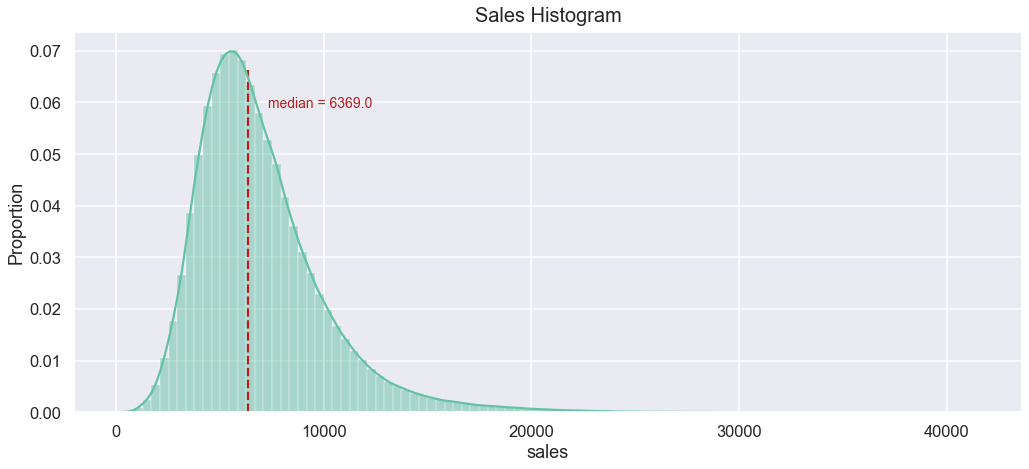

In [29]:
# sales histogram
plt.figure()
ax = sns.histplot(data=df4, x='sales', stat='proportion', bins=100, kde=True)
y_min, y_max = ax.get_ylim()

ax.figure.set_size_inches(17, 7)
ax.set_title('Sales Histogram', fontsize=20, pad=10)

median = np.median(df_numeric['sales'])
ax.vlines(x=median, ymin=0, ymax=y_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax.annotate(f'median = {median}', xy=(median*1.15, y_max*0.8), fontsize=14, color='firebrick')

plt.savefig('../img/univar_analysis/sales_histogram.png')
plt.show()

### <font color='#2365FF'> 4.1.2. Numeric Variable </font>

In [30]:
df_numeric.shape

(844338, 19)

**NUMERIC VARIABLES HISTOGRAMS**

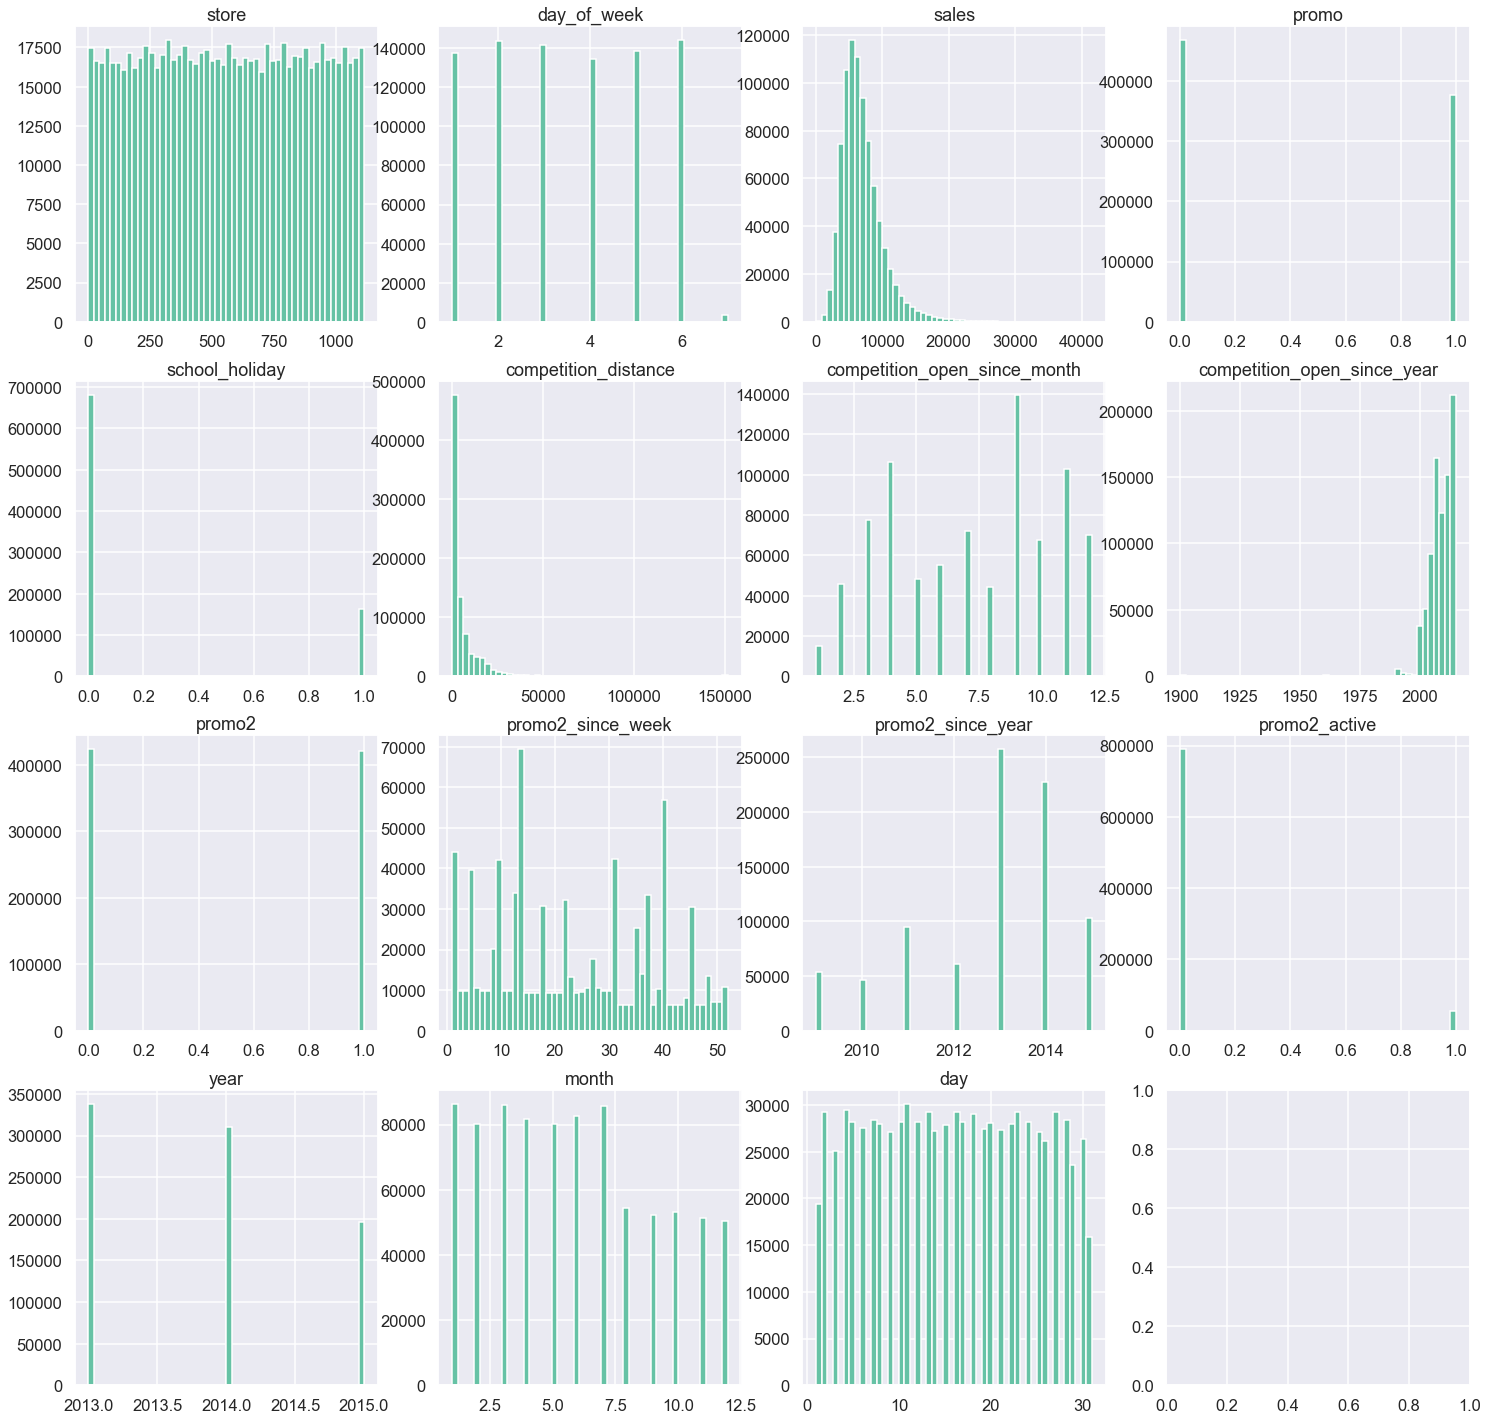

In [31]:
# ploting numeric attributes histograms

axes = list()
n_bins = 50
n=0

fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(25, 25)

for i in range(4):
    for j in range(4):
        if n < 15:
            axes[i][j].hist(df_numeric.iloc[:, n], bins=n_bins)
            axes[i][j].set_title(df_numeric.iloc[:, n].name)
            n += 1

# plt.savefig('../img/univar_analysis/numeric_attr_histograms.png')
fig;

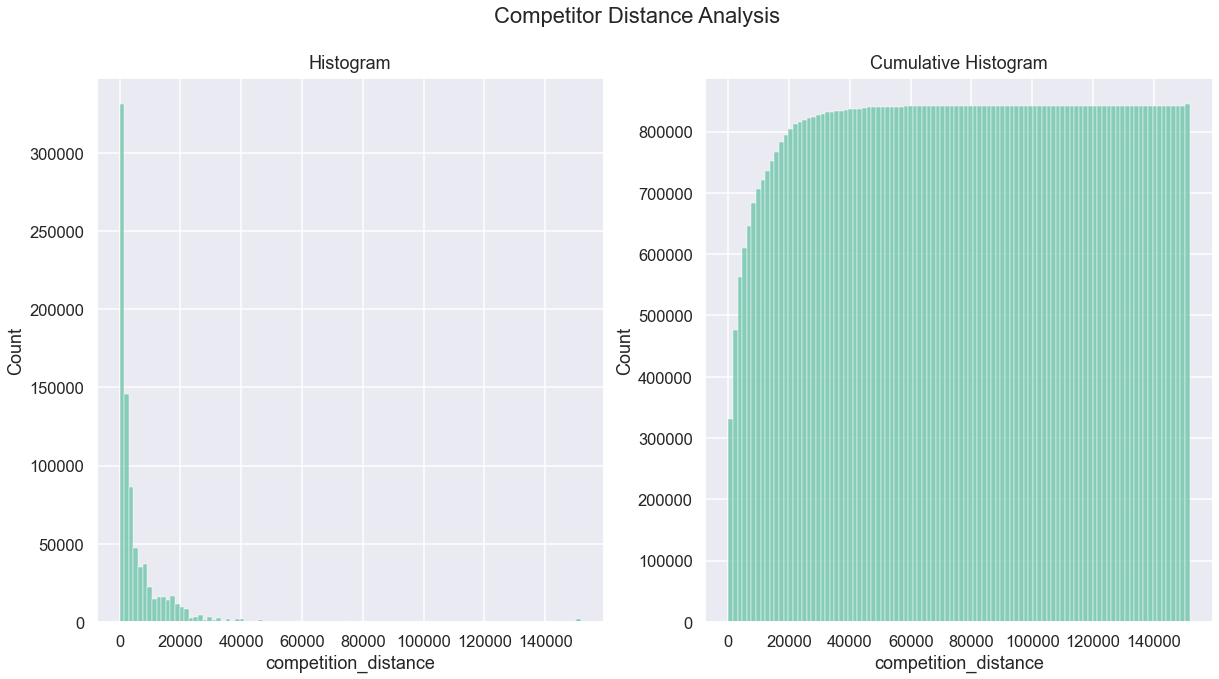

In [32]:
# competition_distance

plt.figure(figsize=(20,10))
plt.suptitle('Competitor Distance Analysis', fontsize=22)

plt.subplot(1, 2, 1)
ax1 = sns.histplot(data=df4, x='competition_distance', bins=100)
ax1.set_title("Histogram", fontsize=18, pad=10)

# cumulative counts as bins increase. 
plt.subplot(1, 2, 2)
ax2 = sns.histplot(data=df4, x='competition_distance', bins=100, cumulative=True)
ax2.set_title("Cumulative Histogram", fontsize=18, pad=10)

# plt.savefig('../img/univar_analysis/competitor_distance.png')
plt.show()

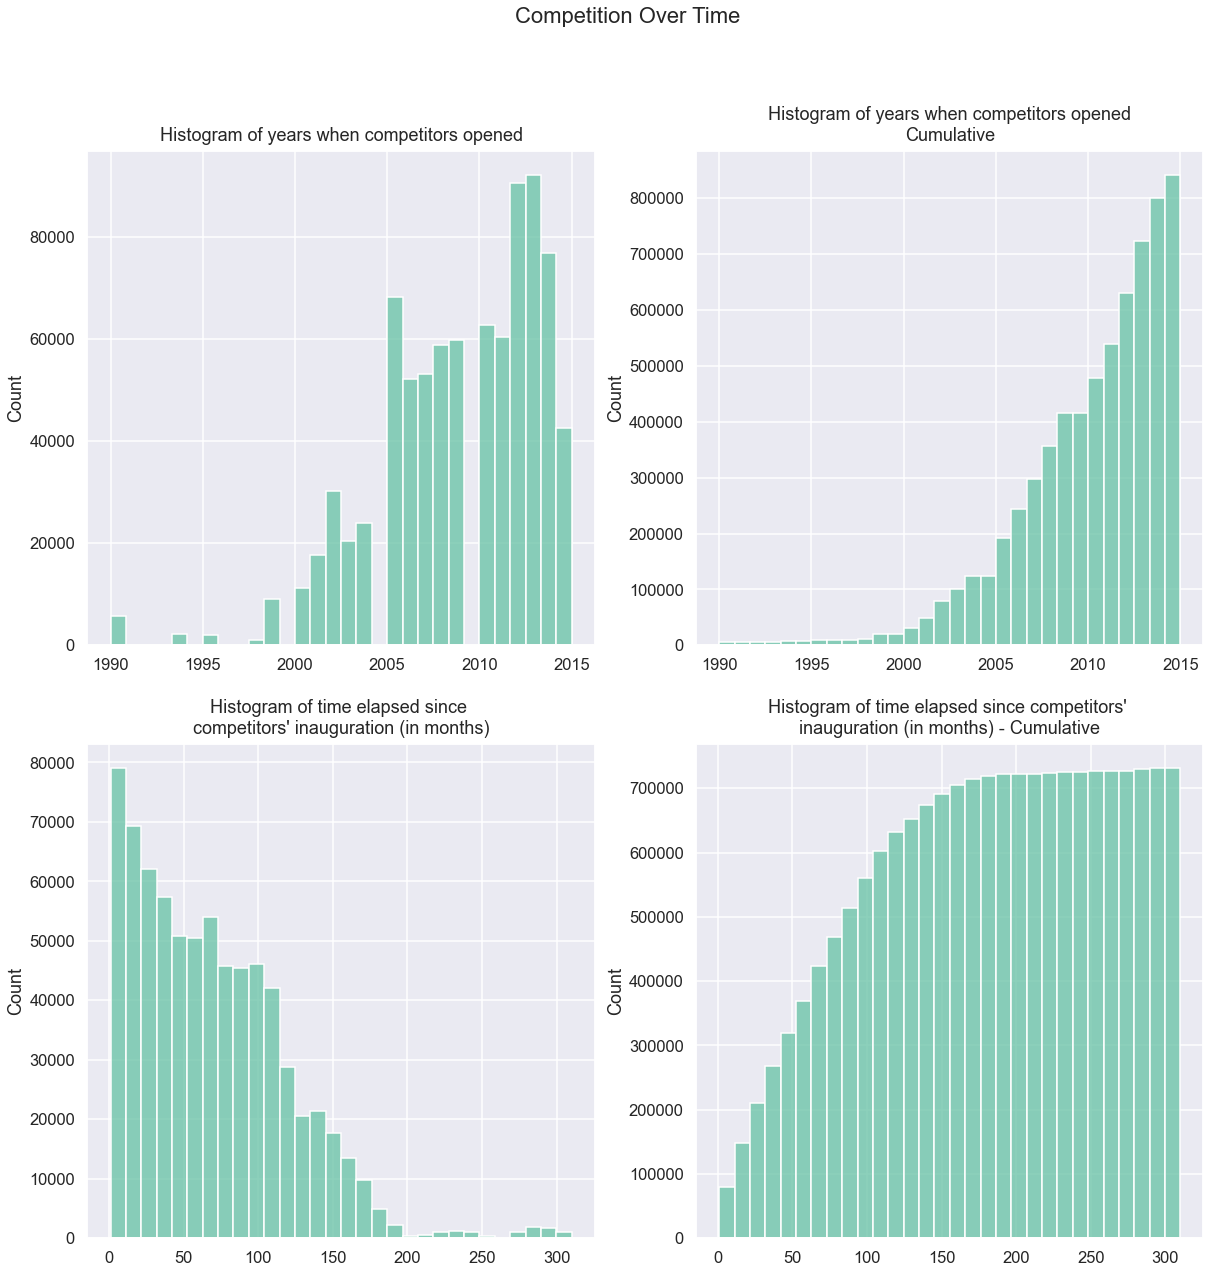

In [33]:
# competition_open_since_year -- competition_months_old

plt.figure(figsize=(20,20))
plt.suptitle('Competition Over Time', fontsize=22)

# analysing values between 1985 and present day (30 years)
plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=df4.query("competition_open_since_year > 1985"), x='competition_open_since_year', bins=30)
ax1.set_title("Histogram of years when competitors opened", fontsize=18, pad=10)
ax1.set_xlabel("")

plt.subplot(2, 2, 2)
ax1 = sns.histplot(data=df4.query("competition_open_since_year > 1985"), x='competition_open_since_year', bins=30, cumulative=True)
ax1.set_title("Histogram of years when competitors opened\nCumulative", fontsize=18, pad=10)
ax1.set_xlabel("")

# analysing values greater than 0 and lower than 360 (30 years)
plt.subplot(2, 2, 3)
ax2 = sns.histplot(data=df4.query("competition_months_old > 0 and competition_months_old < 360"), x='competition_months_old', bins=30)
ax2.set_title("Histogram of time elapsed since \ncompetitors' inauguration (in months)", fontsize=18, pad=10)
ax2.set_xlabel("")

plt.subplot(2, 2, 4)
ax2 = sns.histplot(data=df4.query("competition_months_old > 0 and competition_months_old < 360"), x='competition_months_old', bins=30, cumulative=True)
ax2.set_title("Histogram of time elapsed since competitors' \ninauguration (in months) - Cumulative", fontsize=18, pad=10)
ax2.set_xlabel("")

# plt.savefig('../img/univar_analysis/competition_time.png')
plt.show()

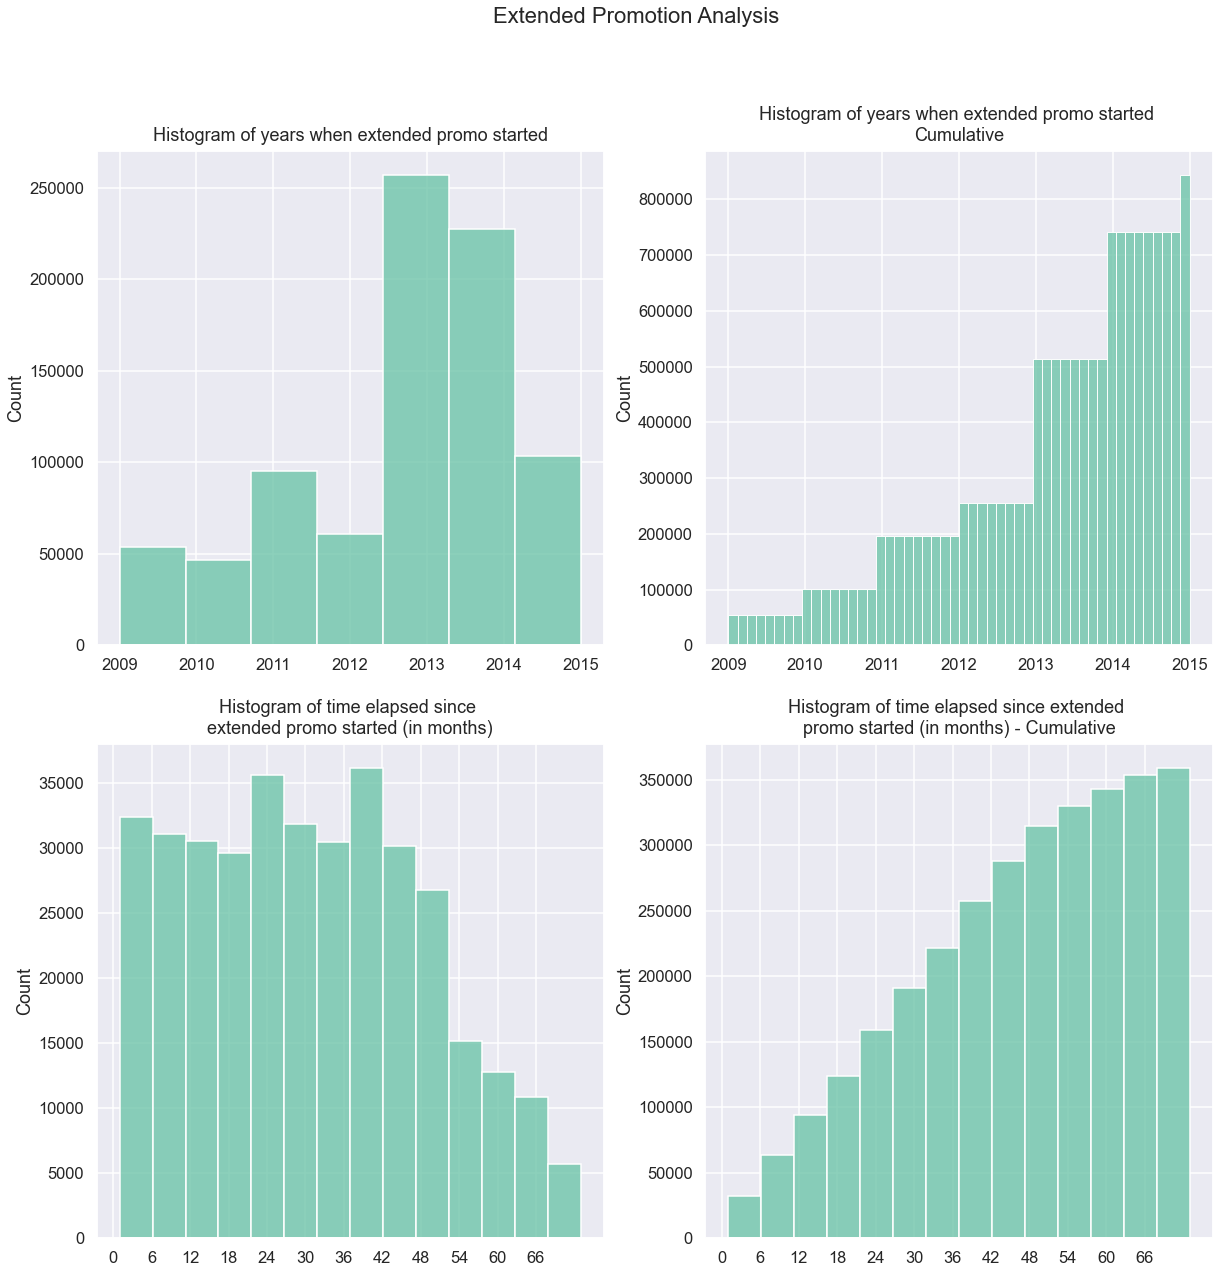

In [34]:
# promo2_since_year -- promo2_months_old

plt.figure(figsize=(20,20))
plt.suptitle('Extended Promotion Analysis', fontsize=22)

# 
plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=df4, x='promo2_since_year', bins = 7)
ax1.set_title("Histogram of years when extended promo started", fontsize=18, pad=10)
ax1.set_xlabel("")

plt.subplot(2, 2, 2)
ax1 = sns.histplot(data=df4, x='promo2_since_year', bins=50, cumulative=True)
ax1.set_title("Histogram of years when extended promo started \nCumulative", fontsize=18, pad=10)
ax1.set_xlabel("")


# analysing values greater than zero
plt.subplot(2, 2, 3)
ax2 = sns.histplot(data=df4.query("promo2_months_old > 0"), x='promo2_months_old', bins=14)
ax2.set_title("Histogram of time elapsed since \nextended promo started (in months)", fontsize=18, pad=10)
ax2.set_xlabel("")
ax2.set_xticks(ticks=np.arange(0, 72, 6))

plt.subplot(2, 2, 4)
ax2 = sns.histplot(data=df4.query("promo2_months_old > 0"), x='promo2_months_old', bins=14, cumulative=True)
ax2.set_title("Histogram of time elapsed since extended \npromo started (in months) - Cumulative", fontsize=18, pad=10)
ax2.set_xlabel("")
ax2.set_xticks(ticks=np.arange(0, 72, 6))

# plt.savefig('../img/univar_analysis/promo2_time.png')
plt.show()

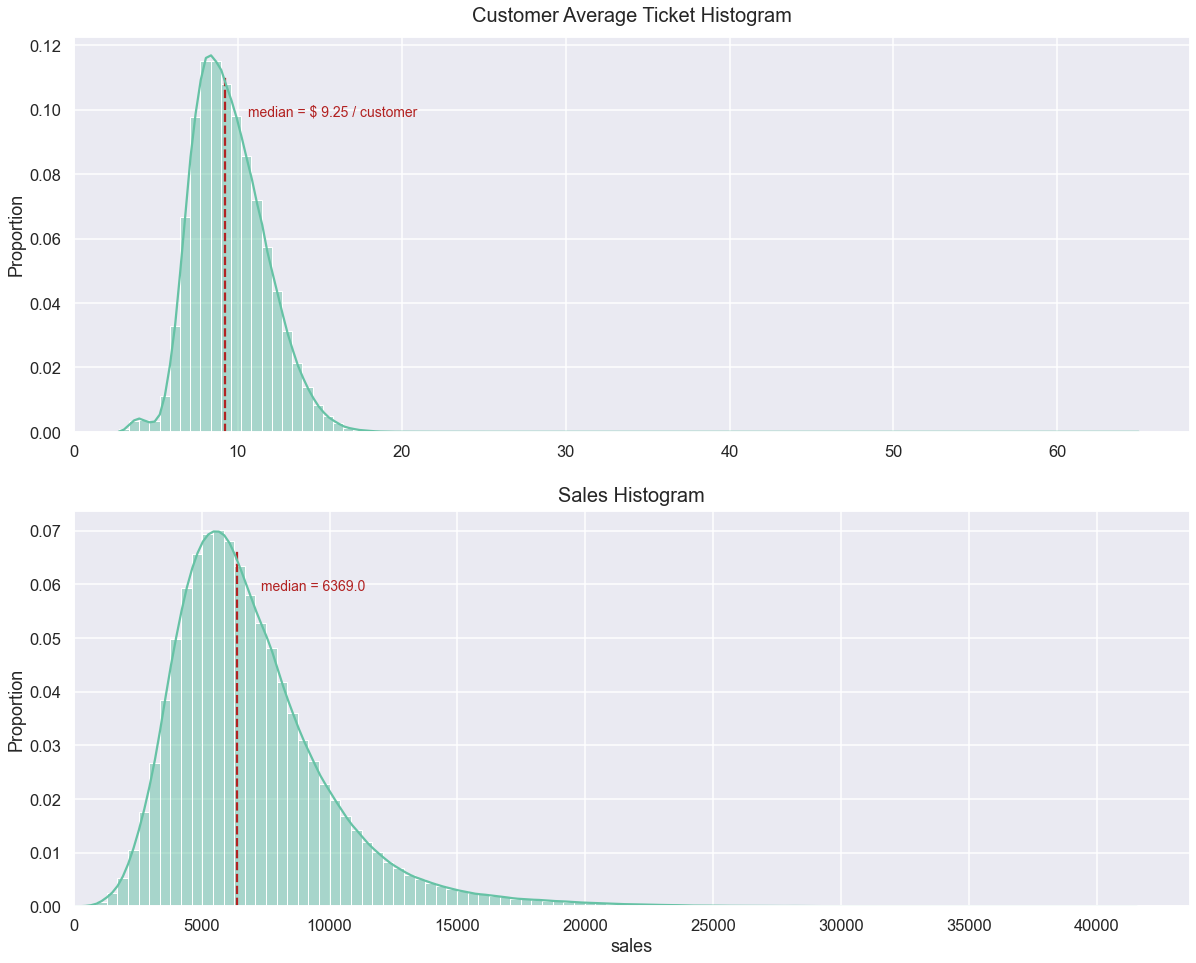

In [35]:
# histograms - customers_avg_ticket AND sales

plt.figure(figsize=(20, 16))

plt.subplot(2, 1, 1)
ax1 = sns.histplot(data=df4, x='customers_avg_ticket', stat='proportion', bins=100, kde=True)
ax1.set_title('Customer Average Ticket Histogram', fontsize=20, pad=15)
ax1.set_xlabel('')
ax1.set_xlim(left=0)
median1 = np.median(df4['customers_avg_ticket'])
_, y1_max = ax1.get_ylim()
ax1.vlines(x=median1, ymin=0, ymax=y1_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax1.annotate(f'median = $ {median1} / customer', xy=(median1*1.15, y1_max*0.8), fontsize=14, color='firebrick')


plt.subplot(2, 1, 2)
ax2 = sns.histplot(data=df4, x='sales', stat='proportion', bins=100, kde=True)
ax2.set_title('Sales Histogram', fontsize=20, pad=10)
ax2.set_xlim(left=0)
median2 = np.median(df4['sales'])
_, y2_max = ax2.get_ylim()
ax2.vlines(x=median2, ymin=0, ymax=y2_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax2.annotate(f'median = {median2}', xy=(median2*1.15, y2_max*0.8), fontsize=14, color='firebrick')

# plt.savefig('../img/univar_analysis/customer_ticket_histogram.png')
plt.show()

### <font color='#2365FF'> 4.1.3. Categorical Variable </font>

**STATE HOLIDAY**

In [36]:
df4.query("state_holiday != 'none'").value_counts(subset='state_holiday')

state_holiday
public       694
easter       145
christmas     71
dtype: int64

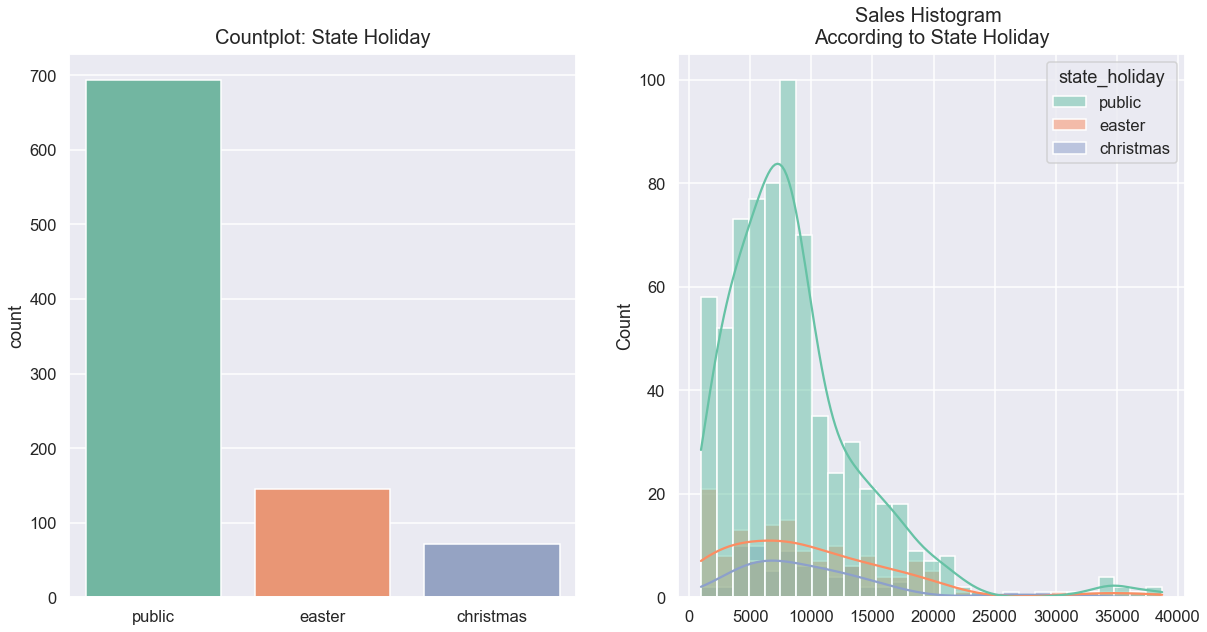

In [37]:
# state_holiday
# not considering regular day -> state_holiday == 'none'

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='state_holiday', data=df4.query("state_holiday != 'none'"))
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: State Holiday', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4.query("state_holiday != 'none'"), hue='state_holiday', kde=True)
ax2.set_title('Sales Histogram \nAccording to State Holiday', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

**STORE TYPES**

In [38]:
df4.value_counts(subset='store_type')

store_type
a    457042
d    258768
c    112968
b     15560
dtype: int64

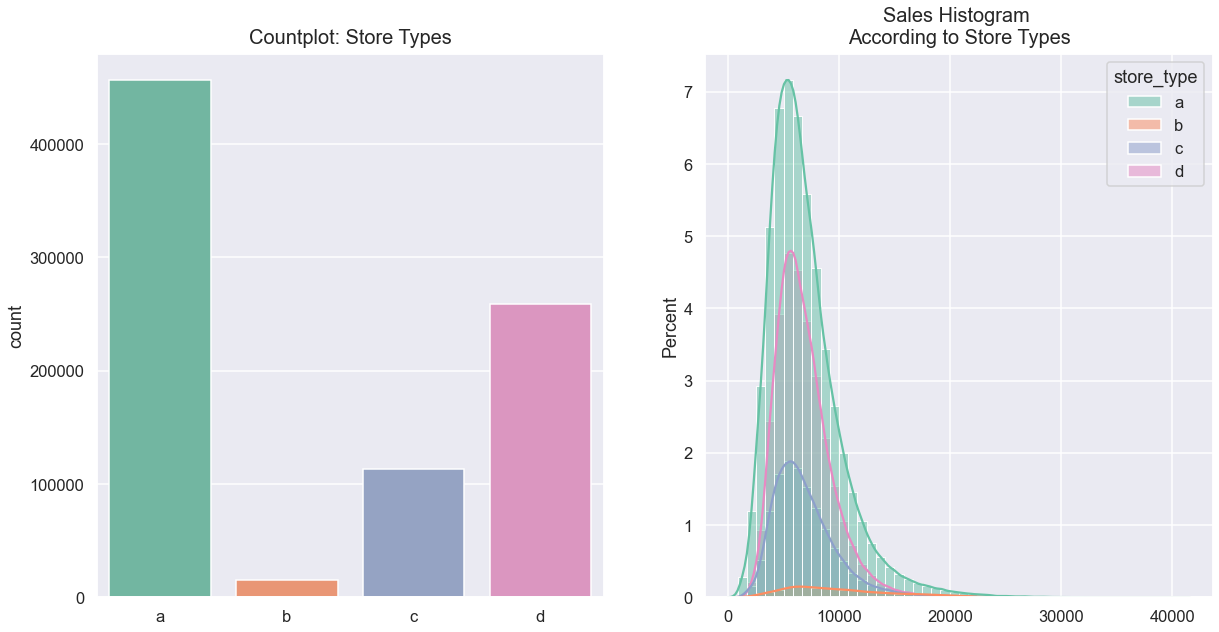

In [39]:
# store_type

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='store_type', data=df4, order=['a','b','c','d'])
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: Store Types', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4, hue='store_type', stat='percent', bins=50, hue_order=['a','b','c','d'], kde=True)
ax2.set_title('Sales Histogram \nAccording to Store Types', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

**ASSORTMENT**

In [40]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

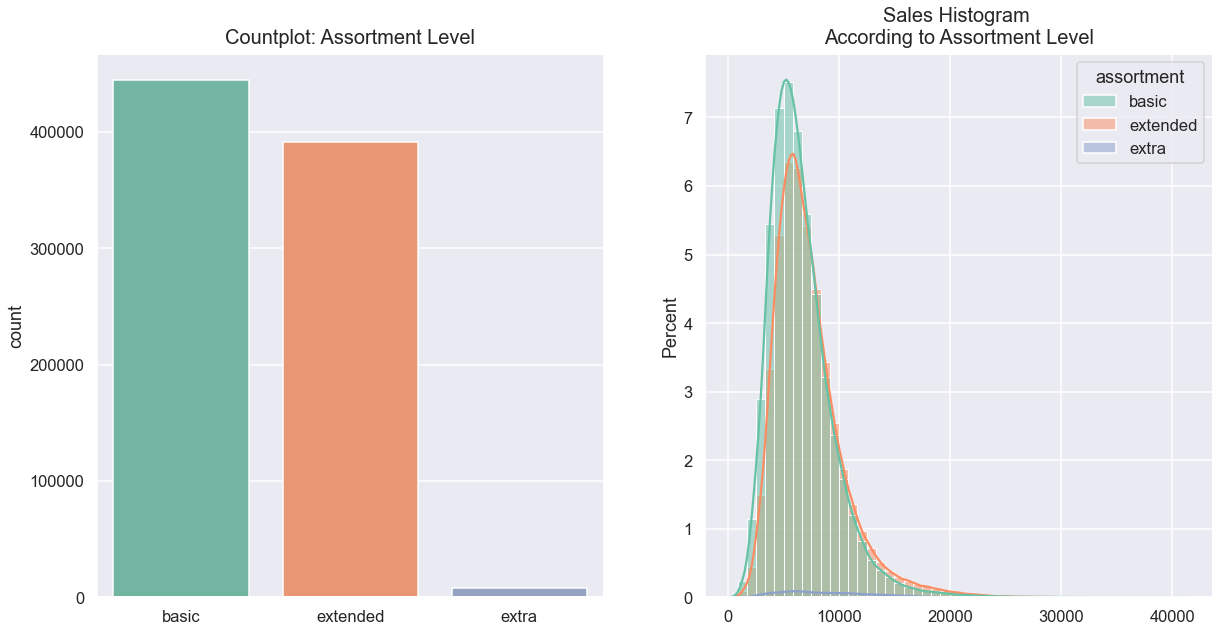

In [41]:
# assortment

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='assortment', data=df4, order=['basic','extended','extra'])
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: Assortment Level', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4, hue='assortment', stat='percent', bins=50, hue_order=['basic','extended','extra'], kde=True)
ax2.set_title('Sales Histogram \nAccording to Assortment Level', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

## <font color='#200CF'> 4.2. Bivariate Analysis </font>

### <font color='#2365FF'> Hypothesis H1. </font>

**The larger the assortment the greater the global sales of the stores should be.**

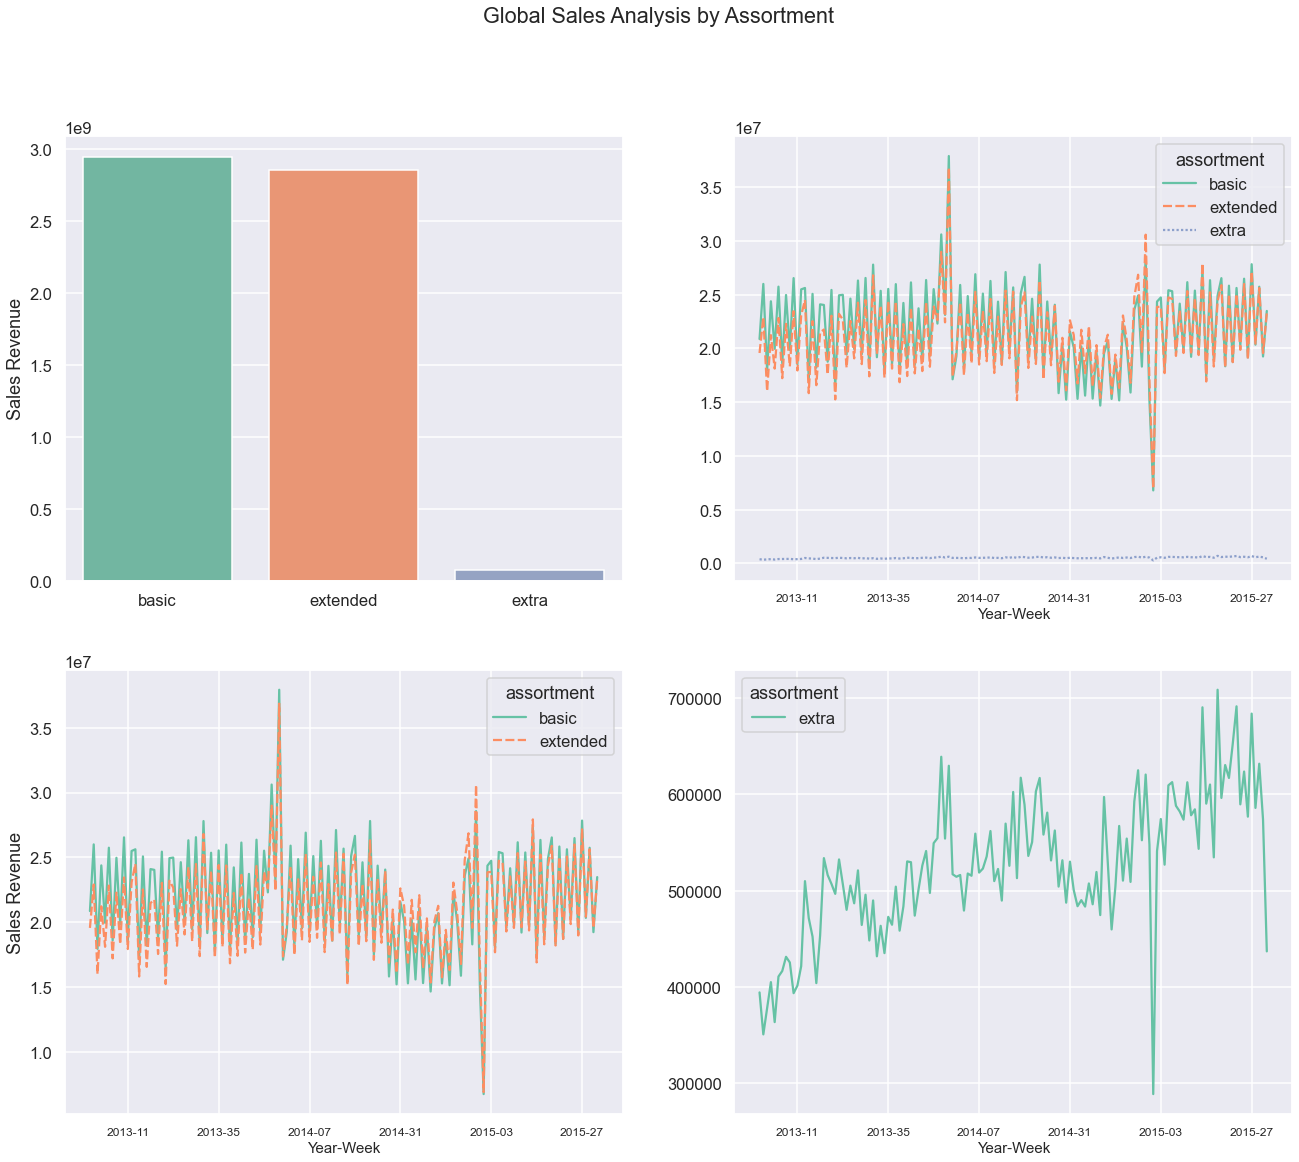

In [42]:
# group by assortment then sum the sales
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# group by year-weak an by assortment then sum the sales
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
# pivoting - each year-week in a row and differents assortments in the columns
aux2 = aux2.pivot(index='year_week', columns='assortment', values='sales')

plt.figure(figsize=(22, 18))
plt.suptitle('Global Sales Analysis by Assortment')

plt.subplot(2, 2, 1)
sns.barplot(x='assortment', y='sales', data=aux1)
plt.xlabel('')
plt.ylabel('Sales Revenue')

plt.subplot(2, 2, 2)
sns.lineplot(data=aux2)
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)

plt.subplot(2, 2, 3)
sns.lineplot(data=aux2[['basic', 'extended']])
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)
plt.ylabel('Sales Revenue')

plt.subplot(2, 2, 4)
sns.lineplot(data=aux2[['extra']])
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)

# plt.savefig('../img/bivar_analysis/assortment_global_sales.png')
plt.show()

<font color='firebrick'>**The number of stores with 'basic' and 'extended' assortment level is much higher (roughly fifty times greater) than the number of stores with 'extra' assortment level, so the sales volume of 'extra' assortment level stores is much smaller when compared to the other types of stores.**</font>

### <font color='#2365FF'> Hypothesis H2. </font>

**The median sales of stores with the largest assortment should be the highest.**

In [43]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').aggregate(func=['count', 'sum', 'median']).droplevel(level=0, axis='columns')
aux1

,count,sum,median
assortment,,,
basic,444875,2945750070,6082.0
extended,391254,2856484241,6675.0
extra,8209,70946312,8088.0


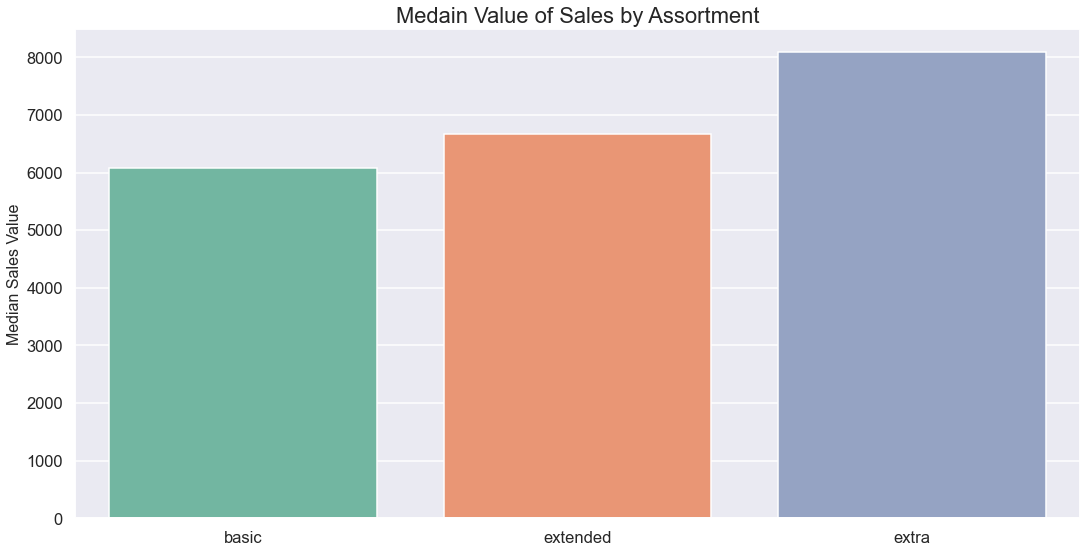

In [44]:
# median sales by assortment - bar plot

aux1 = df4[['assortment', 'sales']].groupby('assortment').aggregate(func=['count', 'sum', 'median']).droplevel(level=0, axis='columns')

plt.figure(figsize=(18, 9))
plt.title('Medain Value of Sales by Assortment', fontsize=22)
sns.barplot(x=aux1.index, y='median', data=aux1)
plt.xlabel('')
plt.ylabel('Median Sales Value', fontsize=16)
# plt.savefig('../img/bivar_analysis/assortment_median_sales.png')
plt.show()

**Although the total number of sales of stores with the 'extra' assortment is much smaller, the median sales value of these stores is higher than the median sales value of the other stores.**

In [45]:
# The bootstrap (sampling with replacement from a data set) is a powerful
# tool for assessing the variability of a sample statistic.

# using to calculate the confidence interval for the median sales value,
# according to the store assortment level, with a confidence level of 95%.

# selecting all sales revenue according to the assortment level
sales_basic_assort = df4.loc[df4['assortment'] == 'basic', 'sales']
sales_extended_assort = df4.loc[df4['assortment'] == 'extended', 'sales']
sales_extra_assort = df4.loc[df4['assortment'] == 'extra', 'sales']

# bootstrapp each series of values, take a sample of 500 values, 
# caluculate its median and repeat the process 500 times
boot_basic    = bootstrap(sales_basic_assort, estimate = 'median', n_repeat=500, n_sample=500, ci=99)
boot_extended = bootstrap(sales_extended_assort, estimate = 'median', n_repeat=500, n_sample=500, ci=99)
boot_extra    = bootstrap(sales_extra_assort, estimate = 'median', n_repeat=500, n_sample=500, ci=99)

assortment_bootstrap_statistics = pd.DataFrame([boot_basic, boot_extended, boot_extra], 
                                               columns = ['statistic_mean', 'standard_error', 'lower_ci', 'upper_ci'], 
                                               index   = ['basic', 'extended', 'extra'])
assortment_bootstrap_statistics

,statistic_mean,standard_error,lower_ci,upper_ci
basic,6081.494,132.868405,5718.385,6398.1250
extended,6680.280,146.200115,6345.450,7045.2975
extra,8087.020,261.382066,7458.415,8777.0525


### <font color='#2365FF'> Hypothesis H3. </font>

**The volume of sales varies according to the type of the store.**

In [46]:
# group by assortment then sum the sales
aux1 = df4[['store_type', 'sales']].groupby('store_type').sum().reset_index()
aux1['sales_share'] = aux1['sales'] / aux1['sales'].sum()
aux1

,store_type,sales,sales_share
0,a,3165334859,0.538947
1,b,159231395,0.027112
2,c,783221426,0.133356
3,d,1765392943,0.300586


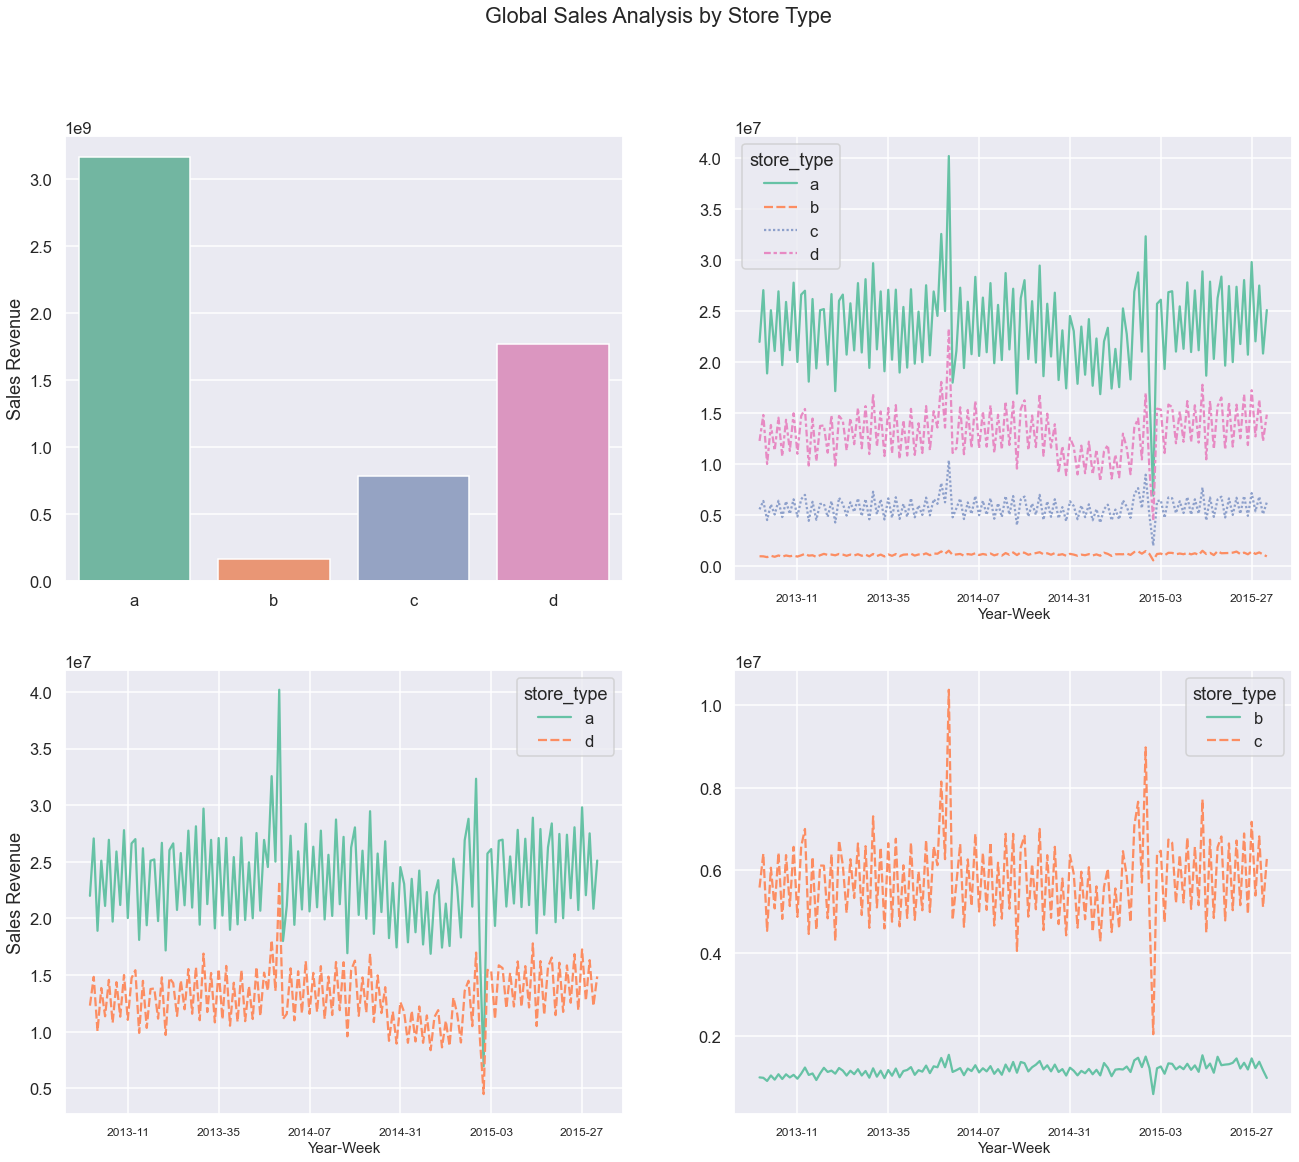

In [47]:
# group by assortment then sum the sales
aux1 = df4[['store_type', 'sales']].groupby('store_type').sum().reset_index()
# group by year-weak an by assortment then sum the sales
aux2 = df4[['year_week', 'store_type', 'sales']].groupby(['year_week', 'store_type']).sum().reset_index()
# pivoting - each year-week in a row and differents assortments in the columns
aux2 = aux2.pivot(index='year_week', columns='store_type', values='sales')

plt.figure(figsize=(22, 18))
plt.suptitle('Global Sales Analysis by Store Type')

plt.subplot(2, 2, 1)
sns.barplot(x='store_type', y='sales', data=aux1)
plt.xlabel('')
plt.ylabel('Sales Revenue')

plt.subplot(2, 2, 2)
sns.lineplot(data=aux2)
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)

plt.subplot(2, 2, 3)
sns.lineplot(data=aux2[['a', 'd']])
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)
plt.ylabel('Sales Revenue')

plt.subplot(2, 2, 4)
sns.lineplot(data=aux2[['b', 'c']])
plt.xticks(ticks=[10,34,58,82,106,130], fontsize=12)
plt.xlabel('Year-Week', fontsize=15)

# plt.savefig('../img/bivar_analysis/store_type_global_sales.png')
plt.show()

<font color='firebrick'>**Approximately 54% of sales come from type A stores, followed by type 3 stores with 30%, 13% come from type C stores and less than 3% from type B stores.**</font>

### <font color='#2365FF'> Hypothesis H4. </font>

**The average value of sales for a specific type of store is higher than the average value for other types (store types: a, b, c, d).**

In [48]:
df4[['store_type', 'sales']].groupby('store_type').aggregate(func=['count', 'sum', 'mean']).reset_index()

store_type   sales                          
               count         sum          mean
0          a  457042  3165334859   6925.697986
1          b   15560   159231395  10233.380141
2          c  112968   783221426   6933.126425
3          d  258768  1765392943   6822.300064

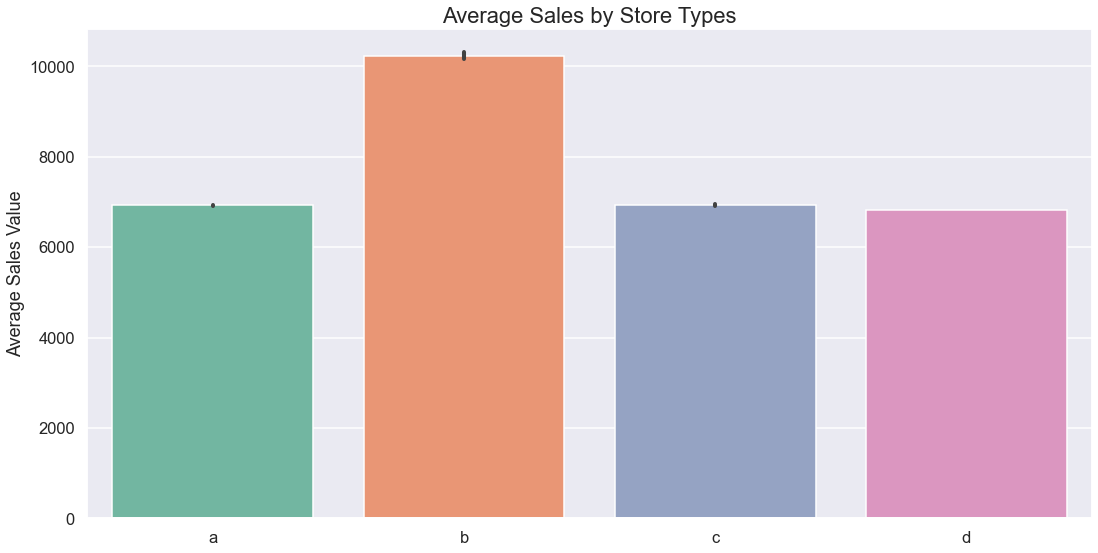

In [49]:
# store-types / assortment - bar plot

# A bar plot represents an estimate of Central Tendency (MEAN) for a numeric variable with the height of
# each rectangle and provides some indication of the uncertainty around that estimate using error bars.

plt.figure(figsize=(18, 9))
plt.title('Average Sales by Store Types', fontsize=22)

# ci -> confidence interval of 95%
sns.barplot(x='store_type', y='sales', order=['a', 'b', 'c', 'd'], data=df4, ci=95)
plt.xlabel('')
plt.ylabel('Average Sales Value')

# plt.savefig('../img/bivar_analysis/store_type_avg_sales.png')
plt.show()

<font color='red'> **The average sales value of type B stores seems to be considerably greater than the average sales value of the other types of stores.** </font>

<b> Performing a Statistic Test </b>

**Hipothesis**: $H_0$ e $H_1$

The null hypothesis always contains an equality claim: equal to; less than or equal to; greater than or equal to. So:

$\mu_1 \Rightarrow$ Average Sales Value of Type B Stores.

$\mu_2 \Rightarrow$ Average Sales Value of Typea A, C or D Stores.

$
\begin{cases}
H_0: \mu_1 \leq \mu_2\\
H_1: \mu_1 > \mu_2
\end{cases}
$

In [50]:
# using DescrStatsW and CompareMeans from statsmodels

# getting 2000 random sample of sales values for each type of store type
sales_store_type_a = df4.loc[df4['store_type'] == 'a', 'sales'].sample(n=2000)
sales_store_type_b = df4.loc[df4['store_type'] == 'b', 'sales'].sample(n=2000)
sales_store_type_c = df4.loc[df4['store_type'] == 'c', 'sales'].sample(n=2000)
sales_store_type_d = df4.loc[df4['store_type'] == 'd', 'sales'].sample(n=2000)

# calculating statistics with DescrStatsW
stats_a = DescrStatsW(sales_store_type_a)
stats_b = DescrStatsW(sales_store_type_b)
stats_c = DescrStatsW(sales_store_type_c)
stats_d = DescrStatsW(sales_store_type_d)

# using CompareMeans
test_b_a = CompareMeans(stats_b, stats_a)
test_b_c = CompareMeans(stats_b, stats_c)
test_b_d = CompareMeans(stats_b, stats_d)

# performing ztest_ind
# H_null: Average Sales Value of Type B Stores is less than or equal to Types (A, C, D) Stores

z_b_a, pvalue_b_a = test_b_a.ztest_ind(alternative='larger', value=0)
z_b_c, pvalue_b_c = test_b_c.ztest_ind(alternative='larger', value=0)
z_b_d, pvalue_b_d = test_b_d.ztest_ind(alternative='larger', value=0)

pd.DataFrame({
    'z': [z_b_a, z_b_c, z_b_d],
    'p_value': [round(pvalue_b_a, 6), round(pvalue_b_c, 6), round(pvalue_b_d, 6)],
    'H_null_rejected': [pvalue_b_a < 0.05, pvalue_b_c < 0.05, pvalue_b_d < 0.05]},
    index=['b_a', 'b_c', 'b_d'])


,z,p_value,H_null_rejected
b_a,23.389473,0.0,True
b_c,24.324759,0.0,True
b_d,25.334950,0.0,True


<font color='black'><b> Store_Type per Assortment -vs- Sales </b></font>

In [51]:
df4[['store_type', 'assortment', 'sales']].groupby(['store_type', 'assortment']).aggregate(func=['count', 'sum', 'mean']).reset_index()

store_type assortment   sales                          
                          count         sum          mean
0          a      basic  286028  1870105131   6538.189027
1          a   extended  171014  1295229728   7573.822775
2          b      basic    6409    71357761  11133.992979
3          b   extended     942    16927322  17969.556263
4          b      extra    8209    70946312   8642.503594
5          c      basic   58554   400260421   6835.748557
6          c   extended   54414   382961005   7037.913129
7          d      basic   93884   604026757   6433.756093
8          d   extended  164884  1161366186   7043.534764

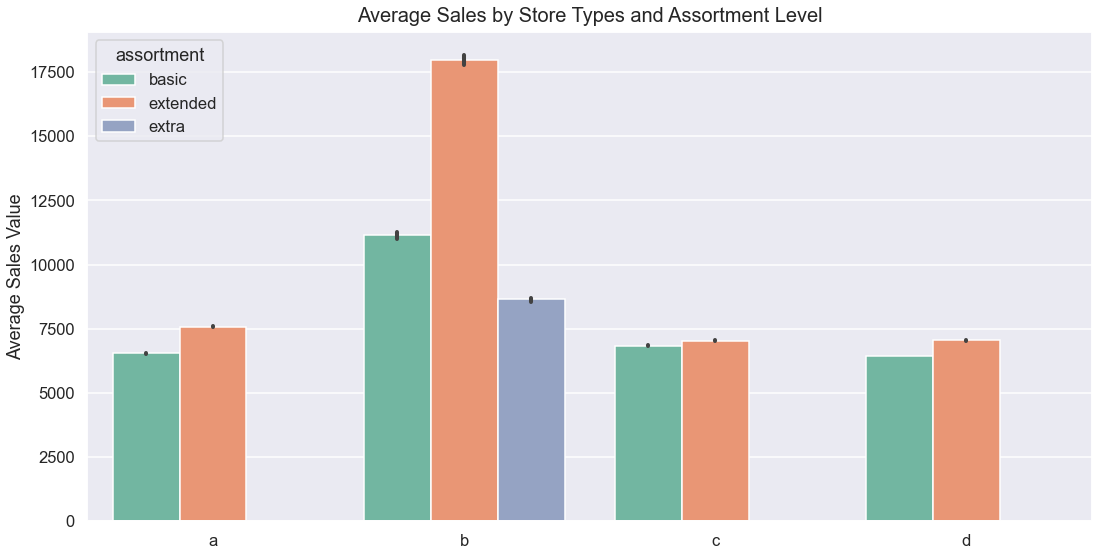

In [52]:
# store-types / assortment - bar plot

# A bar plot represents an estimate of Central Tendency (MEAN) for a numeric variable with the height of
# each rectangle and provides some indication of the uncertainty around that estimate using error bars.

# ci -> confidence interval of 95%

ax = sns.barplot(x='store_type', y='sales', hue='assortment', order=['a', 'b', 'c', 'd'], 
                 hue_order=['basic','extended','extra'], data=df4, ci=95)

ax.figure.set_size_inches(18, 9)
ax.set_title('Average Sales by Store Types and Assortment Level', fontsize=20, pad=10)
ax.set_xlabel('')
ax.set_ylabel('Average Sales Value')

# ax.get_figure().savefig('../img/bivar_analysis/storetype_hue_assortment_avg_sales.png')
ax;

**IMPORTANT:** The average sales value of Type B stores stands out even more when the types of stores are separated by assortment types, as can be seen with the average sales of Type B stores with extended assortment levels, it is still more expressive.

### <font color='#2365FF'> Hypothesis H5. </font>

**The sales revenue of stores are lower the closer the competitors are located.**

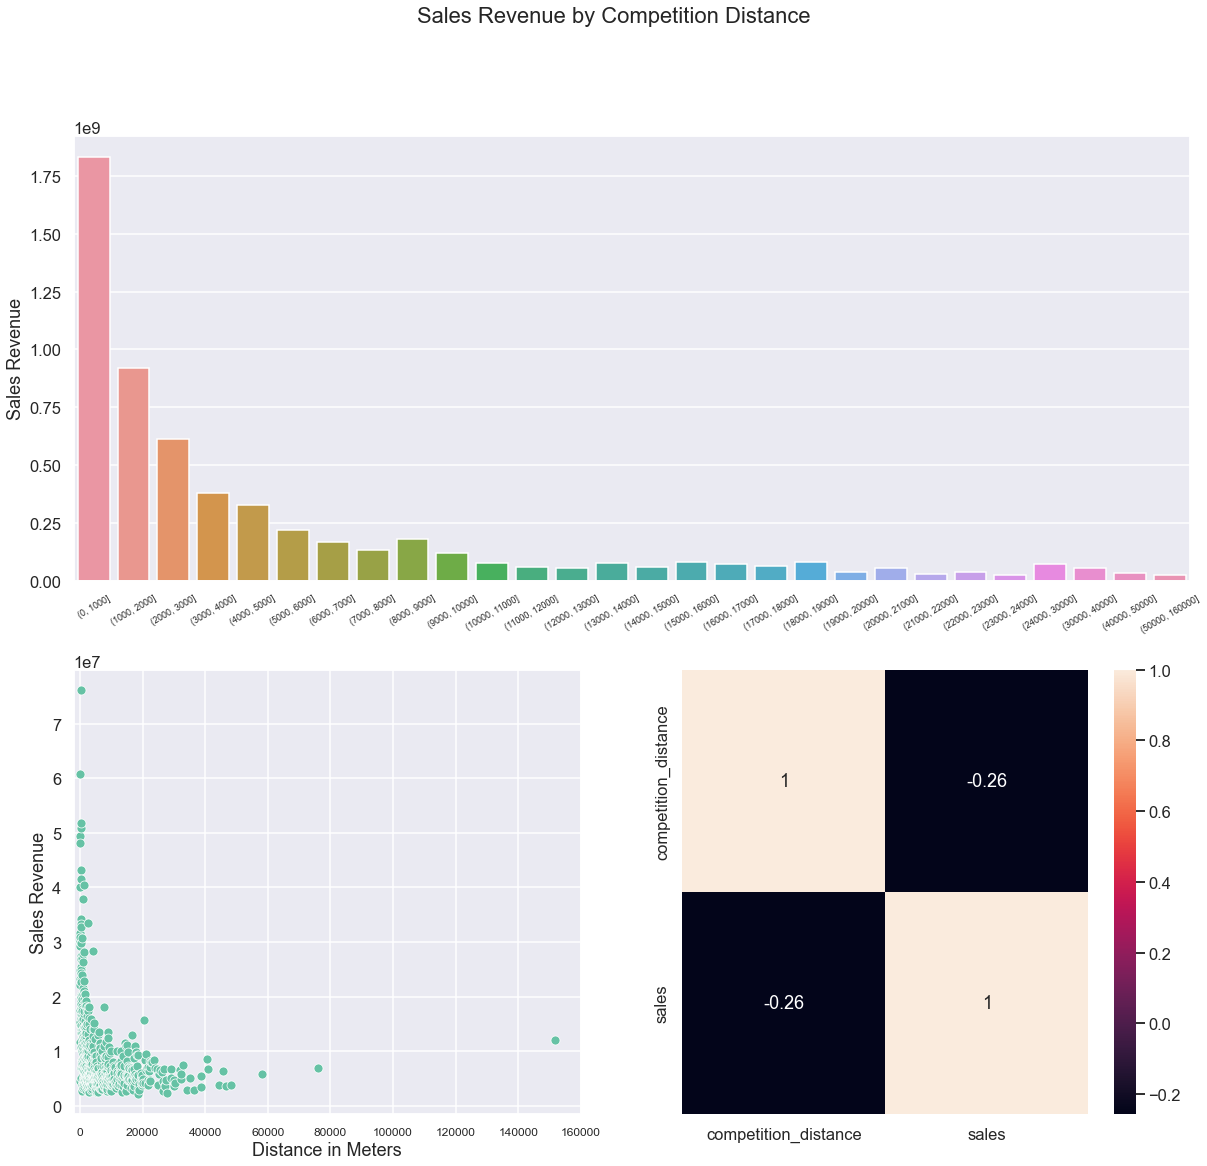

In [53]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 25000, 1000)) + [30000, 40000, 50000, 160000]
aux1['competition_distance_binned'] = pd.cut(x=aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

grid = gridspec.GridSpec(2, 2)
plt.figure(figsize=(20,18))
plt.suptitle('Sales Revenue by Competition Distance', fontsize=22)

plt.subplot(grid[0,:])
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xlabel('')
plt.ylabel('Sales Revenue')
plt.xticks(fontsize=9, rotation=30)

plt.subplot(grid[1,0])
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.ylabel('Sales Revenue')
plt.xlabel('Distance in Meters')
plt.xticks(fontsize=12)
plt.xlim(-2000, 160000)

plt.subplot(grid[1,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.savefig('../img/bivar_analysis/competition_distance_global_sales.png')
plt.show()

<font color='firebrick'>**In fact, the sum of sales of stores with closer competitors is considerably higher than the sum of sales of stores with more distant competitors, especially for distances above 3000 meters.** </font>

### <font color='#2365FF'> Hypothesis H6. </font>

**Regarding the stores with competitors whose distance is less than 1000 meters their average sales value is lower than the average sales value of the other stores.**

In [54]:
print(f"The average sales value of stores whose distance is less than 1000 meters: ${(df4.loc[df4['competition_distance'] < 1000, 'sales'].mean()):.2f}.", end='\n\n')
print(f"The average sales value of stores whose distance is greater than 1000 meters: ${(df4.loc[df4['competition_distance'] >= 1000, 'sales'].mean()):.2f}.")

The average sales value of stores whose distance is less than 1000 meters: $7310.50.

The average sales value of stores whose distance is greater than 1000 meters: $6807.36.


<font color='firebrick'><b>In fact, the data shows that the average sales value of stores with competitors that are located less than 1000 meters away is higher than the average sales value of other stores. </b></font>

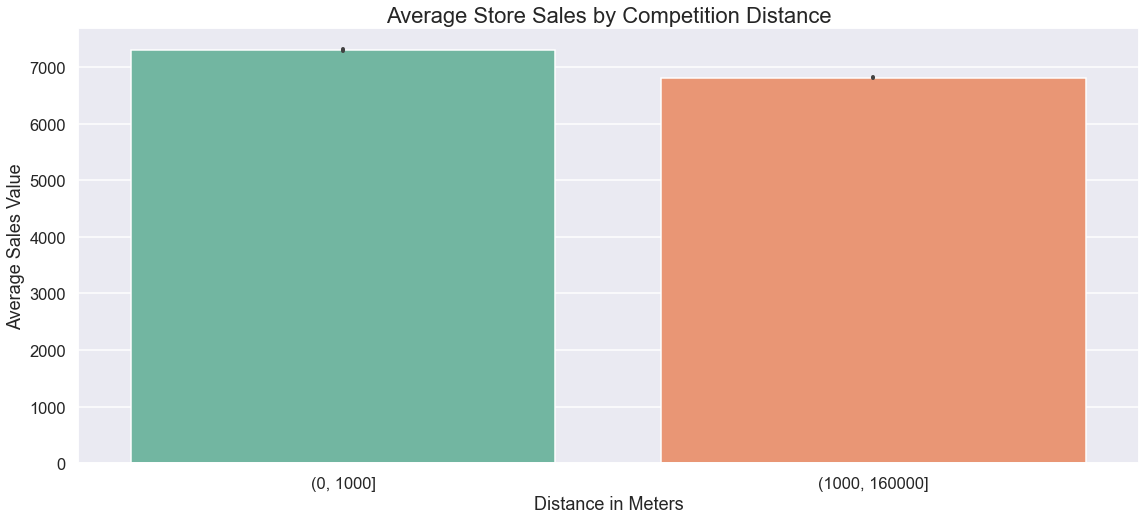

In [55]:
# competition distance avg sales

aux1 = df4[['competition_distance', 'sales']]
aux2 = pd.cut(x=aux1['competition_distance'], bins=[0, 1000, 160000])
aux2.name = 'competition_distance_binned'
aux1 = aux1.join(aux2, how='left')

plt.figure(figsize=(19,8))
plt.title('Average Store Sales by Competition Distance', fontsize=22)

sns.barplot(x='competition_distance_binned', y='sales', data=aux1)
plt.xlabel('Distance in Meters')
plt.ylabel('Average Sales Value')

# plt.savefig('../img/bivar_analysis/competition_distance_avg_sales.png')
plt.show()

**STATISTICAL TESTS TO VERIFY IF THE SETS ARE FROM THE SAME DISTRIBUTUION**

**The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.**

**The alternative hypothesis is that values in one sample are more likely to be larger than the values in the other sample.**

If p_value greater than significance level (usually 5%) then the null hypothesis cannot be rejected.

**Hipothesis**: $H_0$ e $H_1$

$\mu_1 \Rightarrow$ Average Sales Value of Stores whose competitors distance is less than 1000 meters.

$\mu_2 \Rightarrow$ Average Sales Value of Stores whose competitors distance is grater than 1000 meters.

The null hypothesis always contains an equality claim. So:
$
\begin{cases}
H_0: \mu_1 \leq \mu_2\\
H_1: \mu_1 > \mu_2
\end{cases}
$

In [56]:
# unsing ranksums from scipy.stats

# getting 10000 random sample of sales values for each distance
sales_less_1k = df4.loc[df4['competition_distance'] < 1000, 'sales'].sample(10000)
sales_greater_1k = df4.loc[df4['competition_distance'] >= 1000, 'sales'].sample(10000)

statistic, p_value = ranksums(sales_less_1k, sales_greater_1k, alternative='greater')

print(f'p_value: {p_value:.6f}')

p_value: 0.000000


<font color='firebrick'><b>Once p_value is less than 5% (significance level) it can be said that the sales values of stores with competitors whose distance is less than 1000 meters is, in fact, higher than the sales values of the other stores, just the opposite of the initial assumption set out in Hypotheses f.</b></font>

### <font color='#2365FF'> Hypothesis H7. </font>

**The total sales revenue of stores with competitors for a longer time should be higher.**

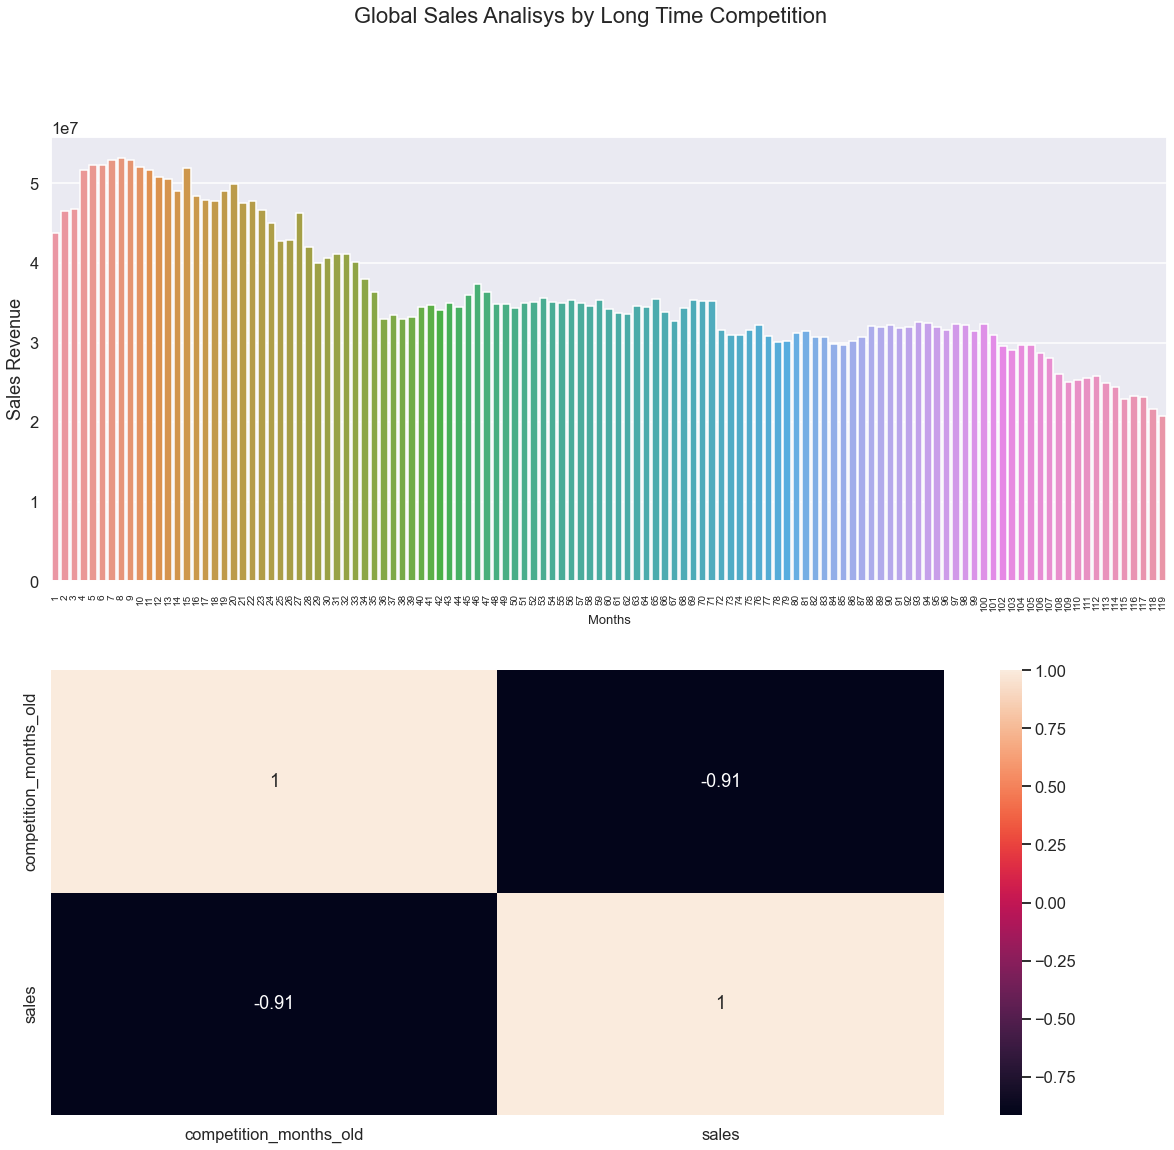

In [57]:
aux1 = df4[(df4['competition_months_old'] > 0) & (df4['competition_months_old'] < 120)][['competition_months_old', 'sales']].groupby('competition_months_old').sum().reset_index()

plt.figure(figsize=(20, 18))
plt.suptitle('Global Sales Analisys by Long Time Competition', fontsize=22)

plt.subplot(2, 1, 1)
sns.barplot(x='competition_months_old', y='sales', data=aux1)
plt.xlabel('Months', fontsize=13)
plt.ylabel('Sales Revenue')
plt.xticks(fontsize=10, rotation=90)

plt.subplot(2, 1, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.savefig('../img/bivar_analysis/competition_months_global_sales.png')
plt.show()

<font color='firebrick'>**Stores with more recent competitors haver higher total sales values than stores with older competitors.**

**However, it is important to emphasize that there has been a great increase in the opening of competitors in recent years, so more stores have started to have competitors nearby.**

### <font color='#2365FF'> Hypothesis H8. </font>

***The average sales values of stores whose competitors opened less than 18 months ago are lower than the average values of other stores.***

In [58]:
# competition_months_old

sales_competition_18_less = df4[(df4['competition_months_old'] < 18) & (df4['competition_months_old'] > 0)]['sales']
print(f"The average sales value of stores whose competitors opened less than 18 months ago: ${sales_competition_18_less.mean():.2f}.", end='\n\n')

sales_competition_18_more = df4[df4['competition_months_old'] > 18]['sales']
print(f"The average sales value of stores whose competitors opened more than 18 months ago: ${sales_competition_18_more.mean():.2f}.")

The average sales value of stores whose competitors opened less than 18 months ago: $7063.62.

The average sales value of stores whose competitors opened more than 18 months ago: $6913.46.


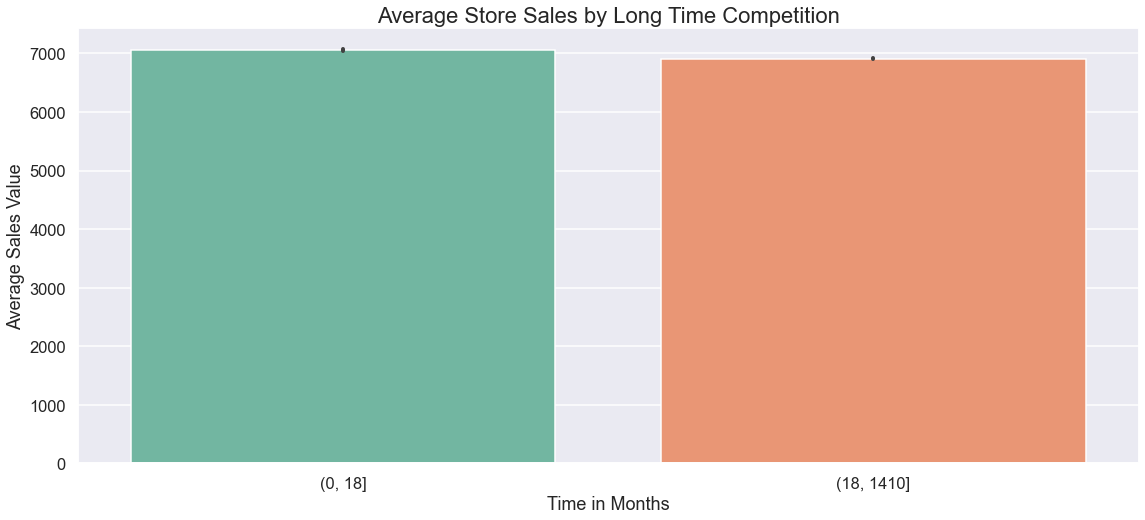

In [59]:
# competition_months_old average sales bar plot

aux1 = df4.loc[df4['competition_months_old'] > 0, ['competition_months_old', 'sales']]
aux2 = pd.cut(x=aux1['competition_months_old'], bins=[0, 18, 1410])
aux2.name = 'competition_months_binned'
aux1 = aux1.join(aux2, how='left')

plt.figure(figsize=(19,8))
plt.title('Average Store Sales by Long Time Competition', fontsize=22)

sns.barplot(x='competition_months_binned', y='sales', data=aux1)
plt.xlabel('Time in Months')
plt.ylabel('Average Sales Value')

# plt.savefig('../img/bivar_analysis/competition_months_avg_sales.png')
plt.show()

<font color='firebrick'>**The difference between the averages is less than 3% and the statistical test results state that there is no statistically significant difference between sales of stores with more or less than 18 months of competition.**</font>

**Performing a Boostrap and calculating the confidence interval.**

In [60]:
# selecting all sales revenue according to the competition time - greater or less than 18 months
# less than 18 months but greater than zero
sales_competition_18_less = df4[(df4['competition_months_old'] < 18) & (df4['competition_months_old'] > 0)]['sales']
sales_competition_18_more = df4[df4['competition_months_old'] > 18]['sales']

boot_less_18 = bootstrap(sales_competition_18_less, estimate='mean', n_repeat=500, n_sample=1000, ci=95)
boot_more_18 = bootstrap(sales_competition_18_more, estimate='mean', n_repeat=500, n_sample=1000, ci=95)

competition_months_bootstrap_statistics = pd.DataFrame([boot_less_18, boot_more_18], 
                                                       columns=['statistic_mean', 'standard_error', 'lower_ci', 'upper_ci'], 
                                                       index=['less_than_18', 'more_than_18'])
competition_months_bootstrap_statistics

,statistic_mean,standard_error,lower_ci,upper_ci
less_than_18,7056.678638,107.832595,6852.376875,7261.005175
more_than_18,6917.056630,93.040078,6739.111200,7103.636025


### <font color='#2365FF'> Hypothesis H9. </font>

**The sales revenue should be greater when running a promotion (promo) than when not running a promo.**

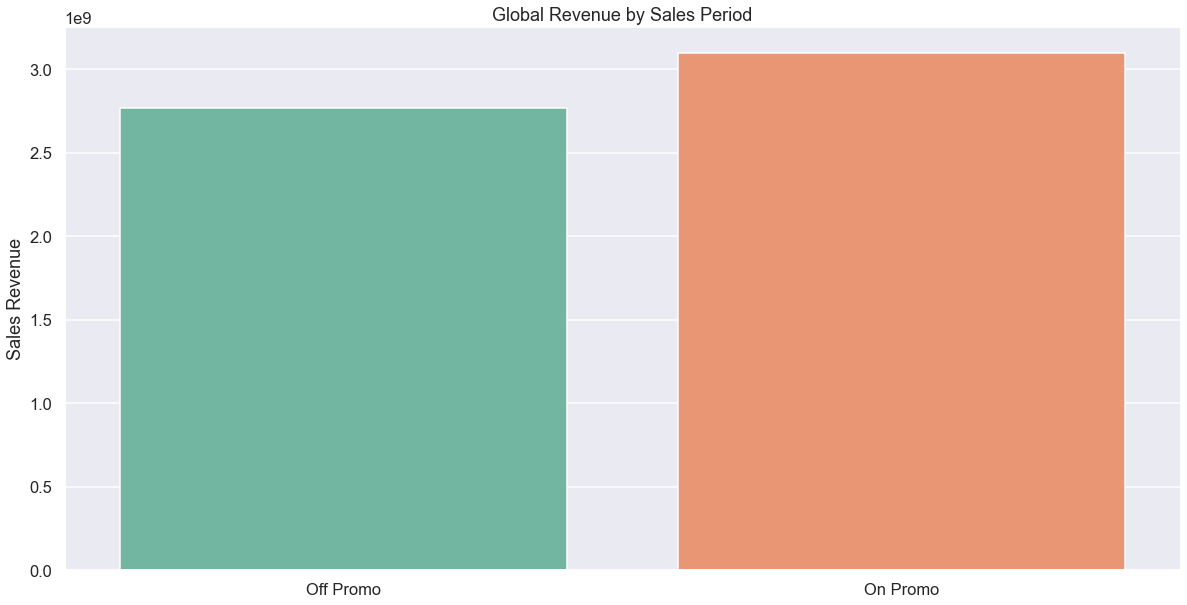

In [61]:
# total sales by promo

aux1 = df4[['promo', 'sales']].groupby('promo').sum().reset_index()

plt.figure(figsize=(20,10))
plt.title('Global Revenue by Sales Period')

sns.barplot(x='promo', y='sales', data=aux1)
plt.xlabel('')
plt.ylabel('Sales Revenue')
plt.xticks(ticks=[0, 1], labels=['Off Promo', 'On Promo'])

# plt.savefig('../img/bivar_analysis/promo_global_sales.png')
plt.show()

### <font color='#2365FF'> Hypothesis H10. </font>

**The average sales value of stores should be greater when running a promotion (promo) than when not running a promo.**

In [62]:
df4[['promo', 'sales']].groupby('promo').aggregate(func=['count', 'sum', 'mean']).reset_index()

promo   sales                         
          count         sum         mean
0     0  467463  2771974337  5929.826183
1     1  376875  3101206286  8228.739731

<font color='firebrick'>**The average sales value of stores during the period they are on promotion (promo) is considerably higher than the average sales value outside the promotion period.** </font>

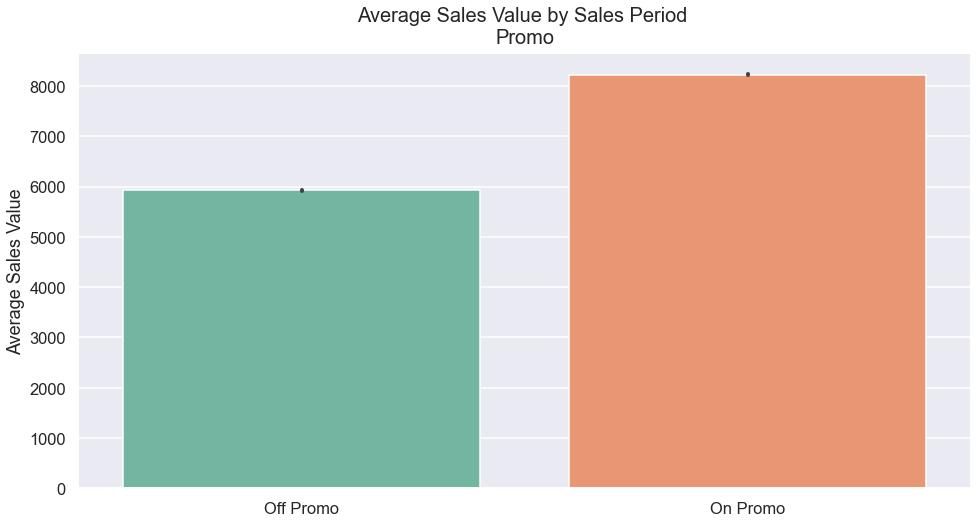

In [63]:
# promo - bar plot

# A bar plot represents an estimate of Central Tendency (MEAN) for a numeric variable with the height of
# each rectangle and provides some indication of the uncertainty around that estimate using error bars.

# ci -> confidence interval of 95%
ax = sns.barplot(x='promo', y='sales', data=df4, ci=95)
ax.figure.set_size_inches(16, 8)
ax.set_title('Average Sales Value by Sales Period \nPromo', fontsize=20, pad=10)
ax.set_xlabel('')
ax.set_ylabel('Average Sales Value')
ax.set_xticklabels(['Off Promo', 'On Promo'])

# ax.get_figure().savefig('../img/bivar_analysis/promo_avg_sales.png')
ax;

### <font color='#2365FF'> Hypothesis H11. </font>

**The average sales value of stores with continuing and consecutive promotion (promo2) should be greater than those that do not have extended promotion.**

In [64]:
df4[['promo2', 'promo', 'sales']].groupby(['promo2', 'promo']).aggregate(func=['count', 'sum', 'mean']).reset_index()

promo2 promo   sales                         
                 count         sum         mean
0      0     0  234287  1482612096  6328.187633
1      0     1  189005  1628930532  8618.452062
2      1     0  233176  1289362241  5529.566684
3      1     1  187870  1472275754  7836.672987

<b>The average sales value of stores that are participating in the extended promotion period is lower than the average sales value of stores that are not participating, whether they have active promotion or not.

It is necessary to identify possible causes for poor sales performance or reassess the marketing strategy for those stores specifically. 

However, it should be noted that the average sales value of stores with extended promotion is higher during the promotion period than outside this period.</b>

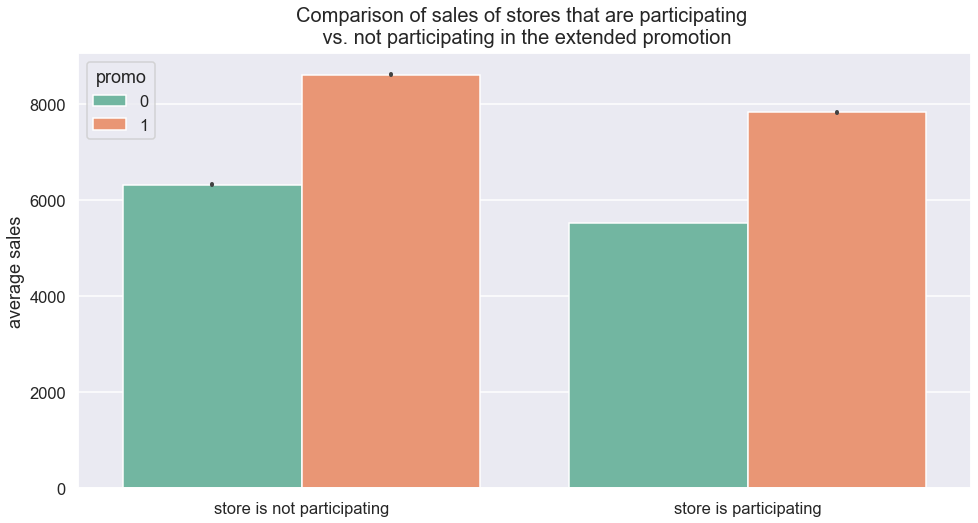

In [65]:
# promo2 - bar plot

# A bar plot represents an estimate of Central Tendency (MEAN) for a numeric variable with the height of
# each rectangle and provides some indication of the uncertainty around that estimate using error bars.

# ci -> confidence interval of 95%
ax = sns.barplot(x='promo2', y='sales', hue='promo', data=df4, ci=95)
ax.figure.set_size_inches(16, 8)
ax.set_title('Comparison of sales of stores that are participating \n vs. not participating in the extended promotion', fontsize=20, pad=10)
ax.set_xlabel('')
ax.set_ylabel('average sales')
ax.set_xticklabels(['store is not participating', 'store is participating'])
# ax.get_figure().savefig('../img/bivar_analysis/promo2_comparison_avg_sales.png')
ax;

In [66]:
# analysing the average sales of promo2 stores only 
# comparing the results:  promo2-on  vs  promo2-off
df4.query("promo2 == 1")[['promo2_active', 'sales']].groupby('promo2_active').aggregate(func=['count', 'sum', 'mean']).reset_index()

promo2_active   sales                         
                  count         sum         mean
0             0  365765  2332077818  6375.891127
1             1   55281   429560177  7770.484922

[Text(0, 0, 'not_active'), Text(1, 0, 'active')]

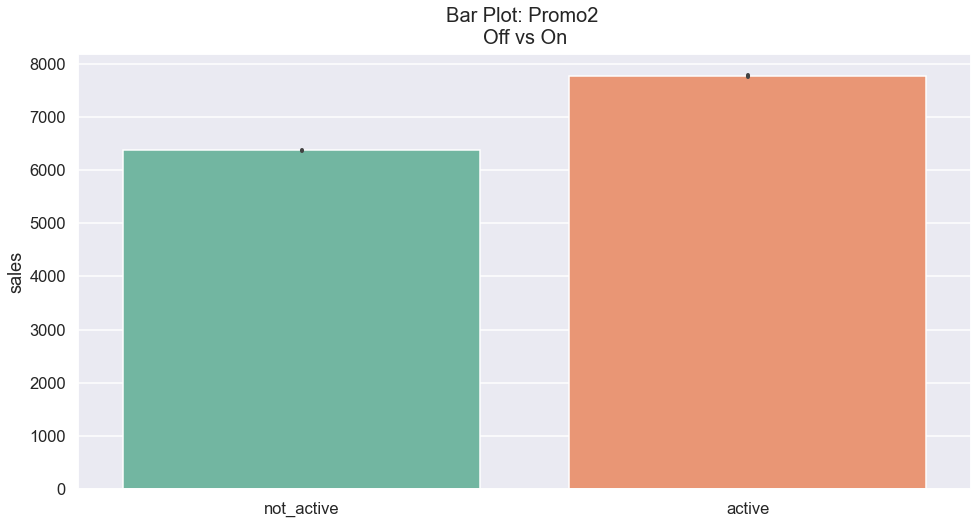

In [67]:
# promo2_active - bar plot

# Analysing stores that participate in Promo2
# comparing the results:  promo2-off  vs promo2-on

ax = sns.barplot(x='promo2_active', y='sales', data=df4.query("promo2 == 1"), ci=95)
ax.figure.set_size_inches(16, 8)
ax.set_title('Bar Plot: Promo2 \nOff vs On', fontsize=20, pad=10)
ax.set_xlabel('')
ax.set_xticklabels(['not_active', 'active'])

### <font color='#2365FF'> Hypothesis H12. </font>

**The sales revenue of stores running promo2 should grow over time.**

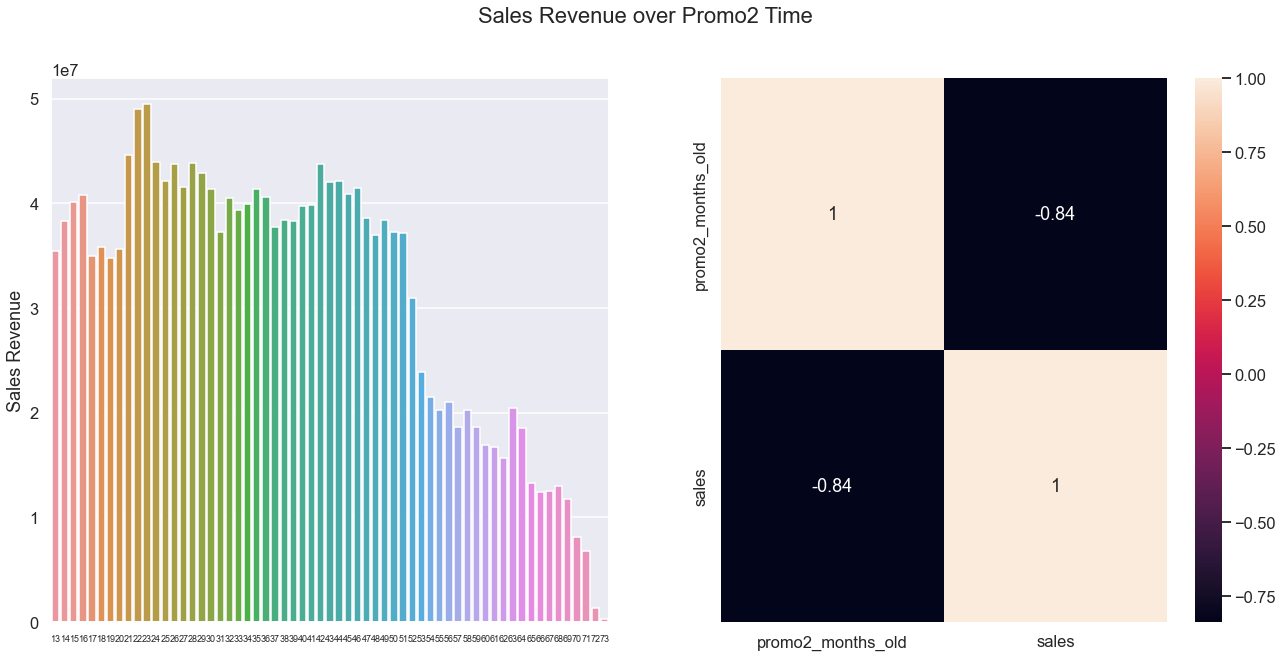

In [68]:
# sales revenue over promo2 time
aux1 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] > 12), ['promo2_months_old', 'sales']].groupby('promo2_months_old').sum().reset_index()

plt.figure(figsize=(22,10))
plt.suptitle('Sales Revenue over Promo2 Time', fontsize=22)

plt.subplot(1, 2, 1)
sns.barplot(x='promo2_months_old', y='sales', data=aux1)
plt.xlabel('')
plt.ylabel('Sales Revenue')
plt.xticks(fontsize=9)

plt.subplot(1, 2, 2)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True)

# plt.savefig('../img/bivar_analysis/promo2_global_sales.png')
plt.show()

### <font color='#2365FF'> Hypothesis H13. </font>

**The median sales value of stores running promo2 for a longer period of time (more than 12 months) should be higher than stores running promo2 for a shorter period of time.**

In [69]:
# stores participating in promo 2 for over 12 months
median_sales_promo2_over_12 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] > 12), 'sales'].median()

# stores participating in promo 2 for less than 12 months
median_sales_promo2_less_12 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] <= 12) & (df4['promo2_months_old'] > 0), 'sales'].median()

print(f'Median sales of stores participating in promo 2 for over 12 months: $ {median_sales_promo2_over_12:.2f}.', end='\n\n')
print(f'Median sales of stores participating in promo 2 for less than 12 months: $ {median_sales_promo2_less_12:.2f}.')

Median sales of stores participating in promo 2 for over 12 months: $ 6122.00.

Median sales of stores participating in promo 2 for less than 12 months: $ 5837.00.


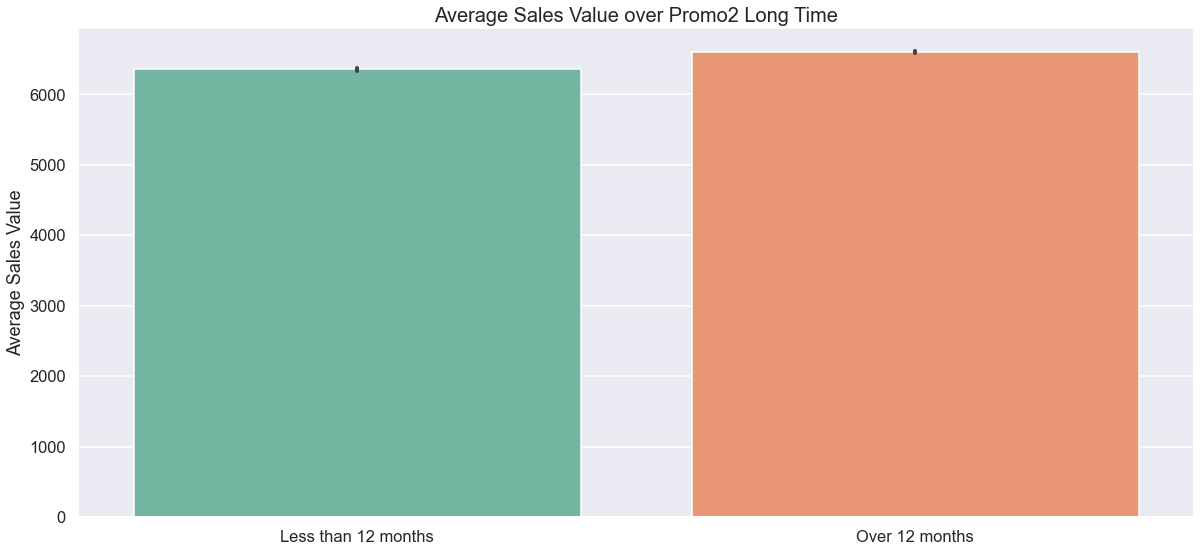

In [70]:
aux1 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] > 0), ['promo2_months_old', 'sales']]
aux2 = pd.cut(x=aux1['promo2_months_old'], bins=[0, 12, 75])
aux2.name = 'promo2_months_binned'
aux1 = aux1.join(aux2, how='left')

plt.figure(figsize=(20,9))
plt.title('Average Sales Value over Promo2 Long Time', fontsize=20)

sns.barplot(x='promo2_months_binned', y='sales', data=aux1)
plt.xlabel('')
plt.ylabel('Average Sales Value')
plt.xticks(ticks=[0, 1], labels=['Less than 12 months', "Over 12 months"])

# plt.savefig('../img/bivar_analysis/promo2_avg_sales.png')
plt.show()

<font color='firebrick'>**Despite being similar values, the median sales value of stores that have been participating in the promo2 for over 12 months is higher.**</font>


**Performing a Boostrap and calculating the confidence interval.**

In [71]:
# selecting all sales of stores participating in promo 2 and splitting into greater than or less than 12 months old

sales_promo2_over_12 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] > 12), 'sales']
# less than 12 months but greater than zero
sales_promo2_less_12 = df4.loc[(df4['promo2'] == 1) & (df4['promo2_months_old'] <= 12) & (df4['promo2_months_old'] > 0), 'sales']

boot_over_12 = bootstrap(sales_promo2_over_12, estimate='median', n_repeat=500, n_sample=1000, ci=95)
boot_less_12 = bootstrap(sales_promo2_less_12, estimate='median', n_repeat=500, n_sample=1000, ci=95)

promo2_months_bootstrap_statistics = pd.DataFrame([boot_over_12, boot_less_12], 
                                                  columns=['statistic_mean', 'standard_error', 'lower_ci', 'upper_ci'], 
                                                  index=['over_12', 'less_than_12'])
promo2_months_bootstrap_statistics

,statistic_mean,standard_error,lower_ci,upper_ci
over_12,6126.261,94.550592,5945.925,6314.025
less_than_12,5836.793,99.804192,5650.950,6028.550


### <font color='#2365FF'> Hypothesis H14. </font>

**The average ticket per customer should be lower during holiday periods.**

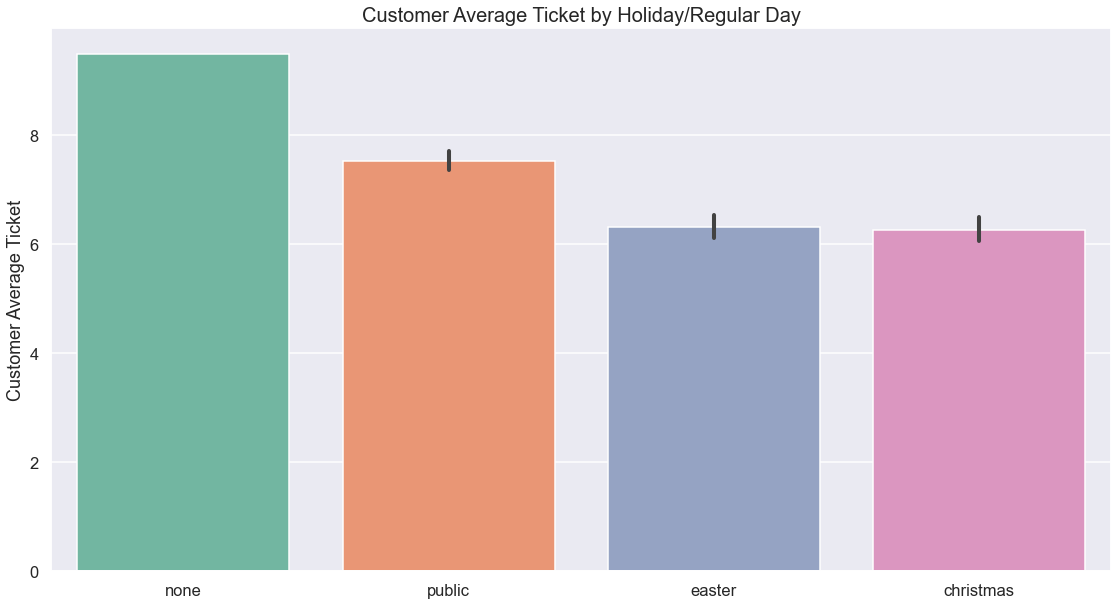

In [72]:
# customer average ticket by state holiday

plt.figure(figsize=(19,10))
plt.title('Customer Average Ticket by Holiday/Regular Day', fontsize=20)
          
sns.barplot(x='state_holiday', y='customers_avg_ticket', data=df4)
plt.xlabel('')
plt.ylabel('Customer Average Ticket')

# plt.savefig('../img/bivar_analysis/customer_avg_ticket_holiday.png')
plt.show()

<font color='firebrick'>**The customer average ticket price is considerably higher in a regular day than during any state holiday.** </font>

In [73]:
aux1 = df4[['state_holiday', 'customers_avg_ticket']].groupby('state_holiday').mean().reset_index()
aux1

,state_holiday,customers_avg_ticket
0,christmas,6.269964
1,easter,6.321028
2,none,9.496068
3,public,7.537288


### <font color='#2365FF'> Hypothesis H15. </font>

**Sales during the Christmas holiday are expected to be the biggest of the year. .**

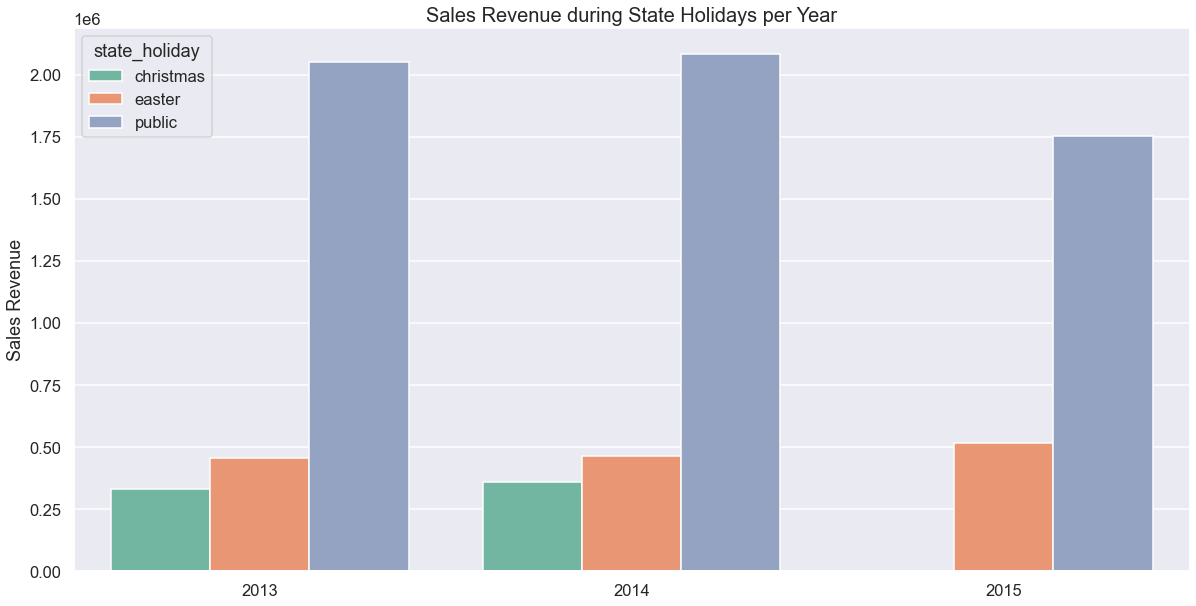

In [74]:
# sales during holidays

aux1 = df4.loc[df4['state_holiday'] != 'none', ['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.figure(figsize=(20,10))
plt.title('Sales Revenue during State Holidays per Year', fontsize=20)

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1)
plt.xlabel('')
plt.ylabel('Sales Revenue')

# plt.savefig('../img/bivar_analysis/state_holiday_global_sales.png')
plt.show()

<font color='firebrick'>**Sales during Christmas are lower than during the other State Holidays.**</font>

### <font color='#2365FF'> Hypothesis H16. </font>

**Stores affected by the closure of public schools on school holidays should sell less.**

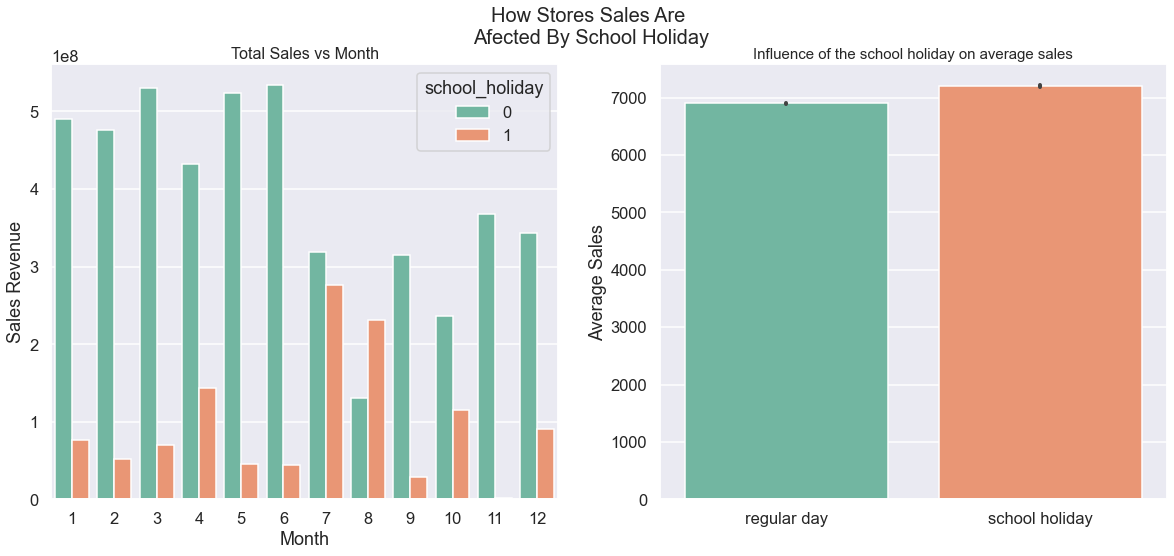

In [75]:
# sales vs school holidays

aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(20,8))
plt.suptitle('How Stores Sales Are \nAfected By School Holiday', fontsize=20)

plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1)
ax1.set_title('Total Sales vs Month', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales Revenue')

plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='school_holiday', y='sales', data=df4)
ax2.set_title('Influence of the school holiday on average sales', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Average Sales')
ax2.set_xticklabels(['regular day', 'school holiday'])

# plt.savefig('../img/bivar_analysis/school_holiday_sales.png')
plt.show()

In [76]:
df4[['school_holiday', 'sales']].groupby('school_holiday').mean()

,sales
school_holiday,
0,6897.207830
1,7200.710282


<font color='firebrick'>**The difference between the average sales values of the stores is less than 5%.**</font>

**Performing a Boostrap and calculating the confidence interval.**

In [77]:
# splitting sales into during school holiday and off school holidays

on_school_holiday = df4.loc[df4['school_holiday'] == 1, 'sales']

# less than 12 months but greater than zero
off_school_holiday = df4.loc[df4['school_holiday'] == 0, 'sales']

boot_on = bootstrap(on_school_holiday, estimate='mean', n_repeat=500, n_sample=1000, ci=95)
boot_off = bootstrap(off_school_holiday, estimate='mean', n_repeat=500, n_sample=1000, ci=95)

school_holiday_bootstrap_statistics = pd.DataFrame([boot_on, boot_off], 
                                                  columns=['statistic_mean', 'standard_error', 'lower_ci', 'upper_ci'], 
                                                  index=['school_holiday', 'not_school_holiday'])
school_holiday_bootstrap_statistics

,statistic_mean,standard_error,lower_ci,upper_ci
school_holiday,7205.133068,102.165977,6997.41455,7400.452125
not_school_holiday,6899.820334,96.391885,6717.20180,7094.560200


### <font color='#2365FF'> Hypothesis H17. </font>

**The revenue in the last quarter of the year should be higher than in the other quarters.**

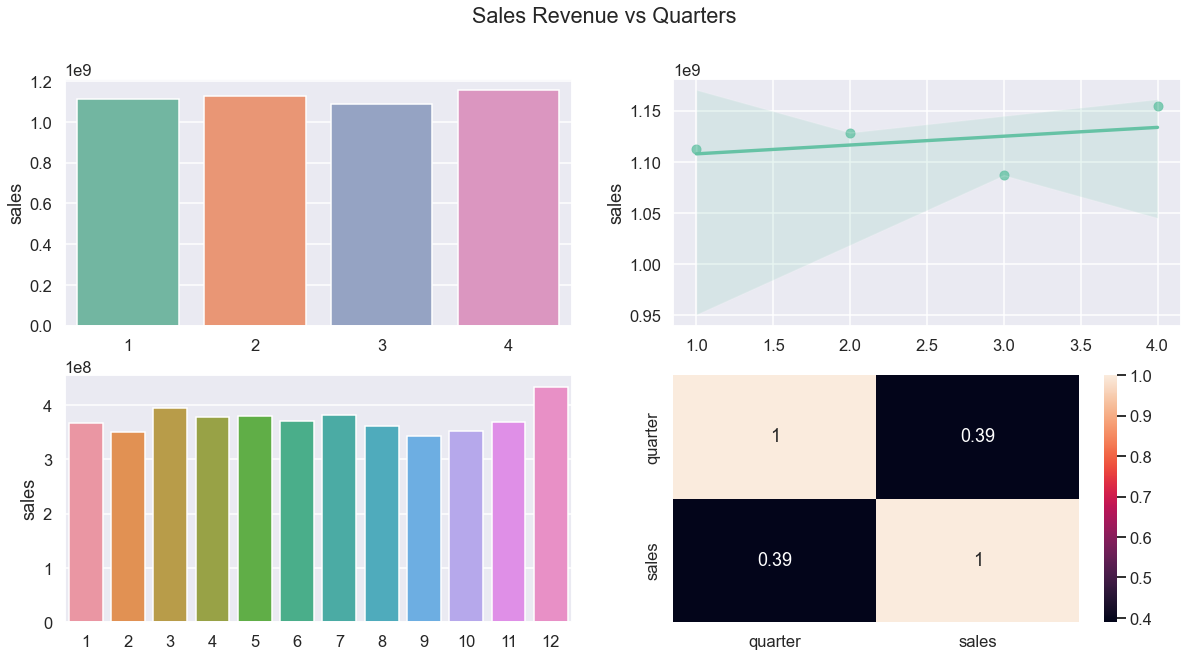

In [78]:
# sales revenue over the quarters of the years

# mapping the quarters
quarter_map = {1:1, 2:1, 3:1,
               4:2, 5:2, 6:2,
               7:3, 8:3, 9:3,
               10:4, 11:4, 12:4}
# the sales data of 2015 stops in july - considering 2013 and 2014 only
aux1 = df4.query("year != 2015")[['month', 'sales']].groupby('month').sum().reset_index()
aux1['quarter'] = aux1['month'].map(quarter_map)
aux2 = aux1[['quarter', 'sales']].groupby('quarter').sum().reset_index()

plt.figure(figsize=(20,10))
plt.suptitle('Sales Revenue vs Quarters')

plt.subplot(2, 2, 1)
ax1 = sns.barplot(x='quarter', y='sales', data=aux2)
ax1.set_xlabel('')
#ax3.set_xticklabels(ticks=[0,1,2,3], labels=['1st', '2nd', '3rd', '4th'])

plt.subplot(2, 2, 2)
ax2 = sns.regplot(x='quarter', y='sales', data=aux2)
ax2.set_xlabel('')

plt.subplot(2, 2, 3)
ax3 = sns.barplot(x='month', y='sales', data=aux1)
ax3.set_xlabel('')

plt.subplot(2, 2, 4)
ax4 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax4.set_xlabel('')

# plt.savefig('../img/bivar_analysis/quarters_global_sales.png')
plt.show()

<font color='firebrick'>**There is an increase in sales in the last quarter of the year, but the difference is not significant in relation to the other quarters**</font>

### <font color='#2365FF'> Hypothesis H18. </font>

**Sales behavior is not constant throughout the month, it should be higher in the first 7 days and decreases in the following weeks.**

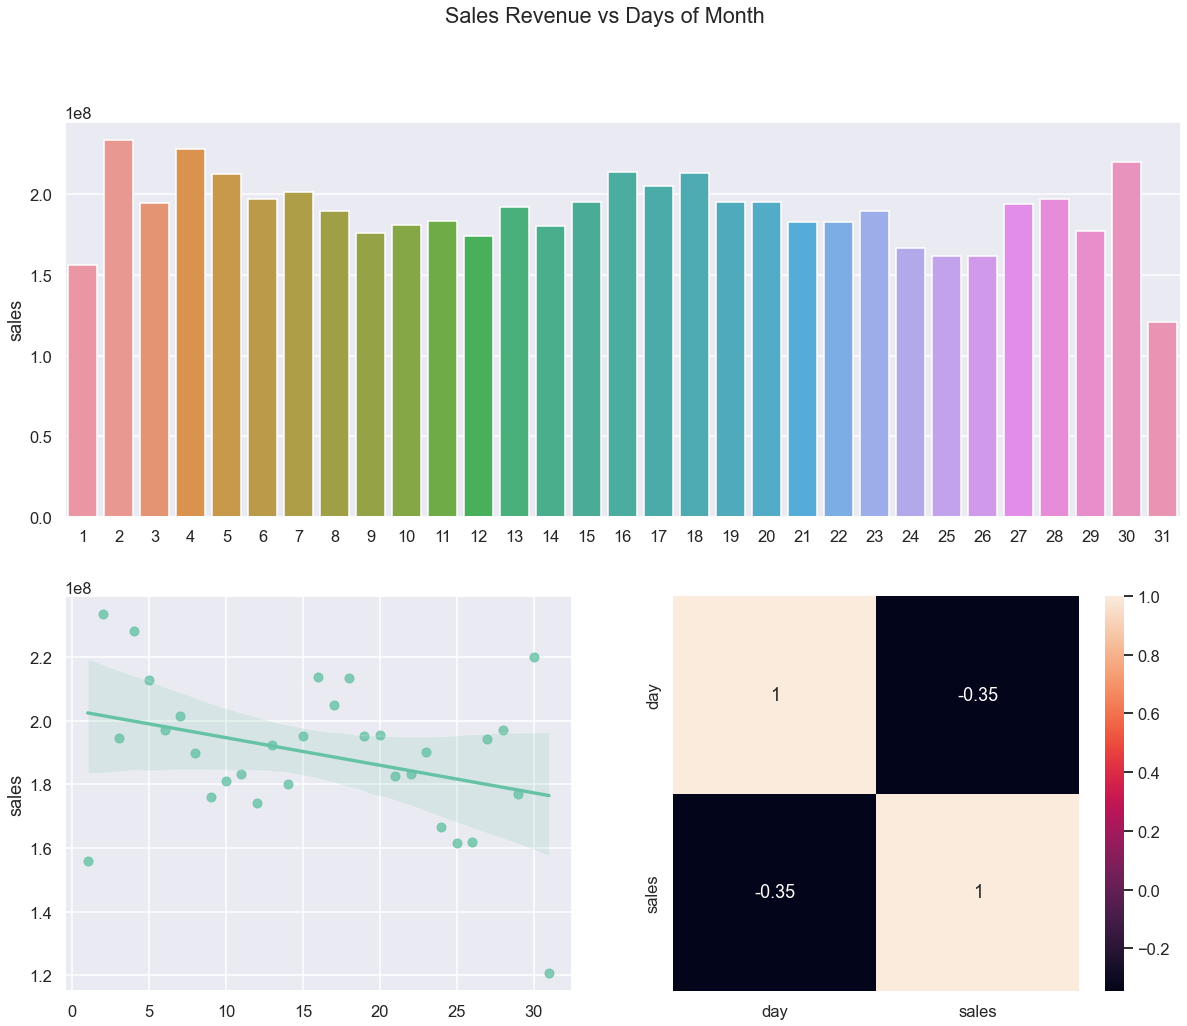

In [79]:
# Sales Revenue vs Days of Month

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

grids = gridspec.GridSpec(nrows=2, ncols=2)
plt.figure(figsize=(20,16))
plt.suptitle('Sales Revenue vs Days of Month')

plt.subplot(grid[0, 0:])
sns.barplot(x='day', y='sales', data=aux1)
plt.xlabel('')

plt.subplot(grid[1, 0])
sns.regplot(x='day', y='sales', data=aux1)
plt.xlabel('')

plt.subplot(grid[1, 1])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.savefig('../img/bivar_analysis/day_global_sales.png')
plt.show()

<font color='firebrick'>**There is a drop in sales throughout the month.**</font>

### <font color='#2365FF'> Hypothesis H19. </font>

**Average sales in the weekend days should be lower than in the other days of the week.**

In [80]:
df4[['day_of_week', 'sales']].groupby('day_of_week').aggregate(func=['count', 'sum', 'mean'])

sales                         
              count         sum         mean
day_of_week                                 
1            137557  1130203012  8216.252259
2            143955  1020411930  7088.409086
3            141922   954962863  6728.786679
4            134626   911177709  6768.214973
5            138633   980555941  7073.034133
6            144052   846317735  5875.084935
7              3593    29551433  8224.723908

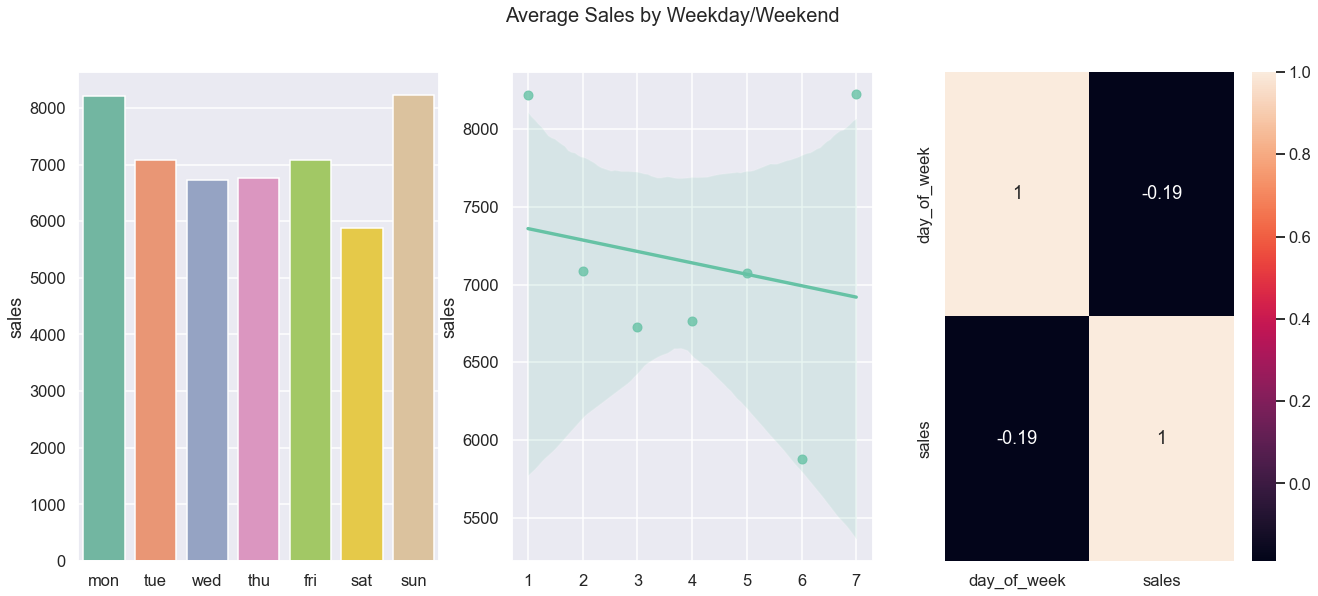

In [81]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(22,9))
plt.suptitle('Average Sales by Weekday/Weekend', fontsize=20)

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.xlabel('')
plt.xticks(ticks=[0,1,2,3,4,5,6], 
           labels=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.xlabel('')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.savefig('../img/bivar_analysis/weekend_avg_sales.png')
plt.show()

## <font color='#200CF'> 4.3. Multivariate Analysis </font>

### <font color='#2365FF'> 4.3.1. Numeric Attributes </font>

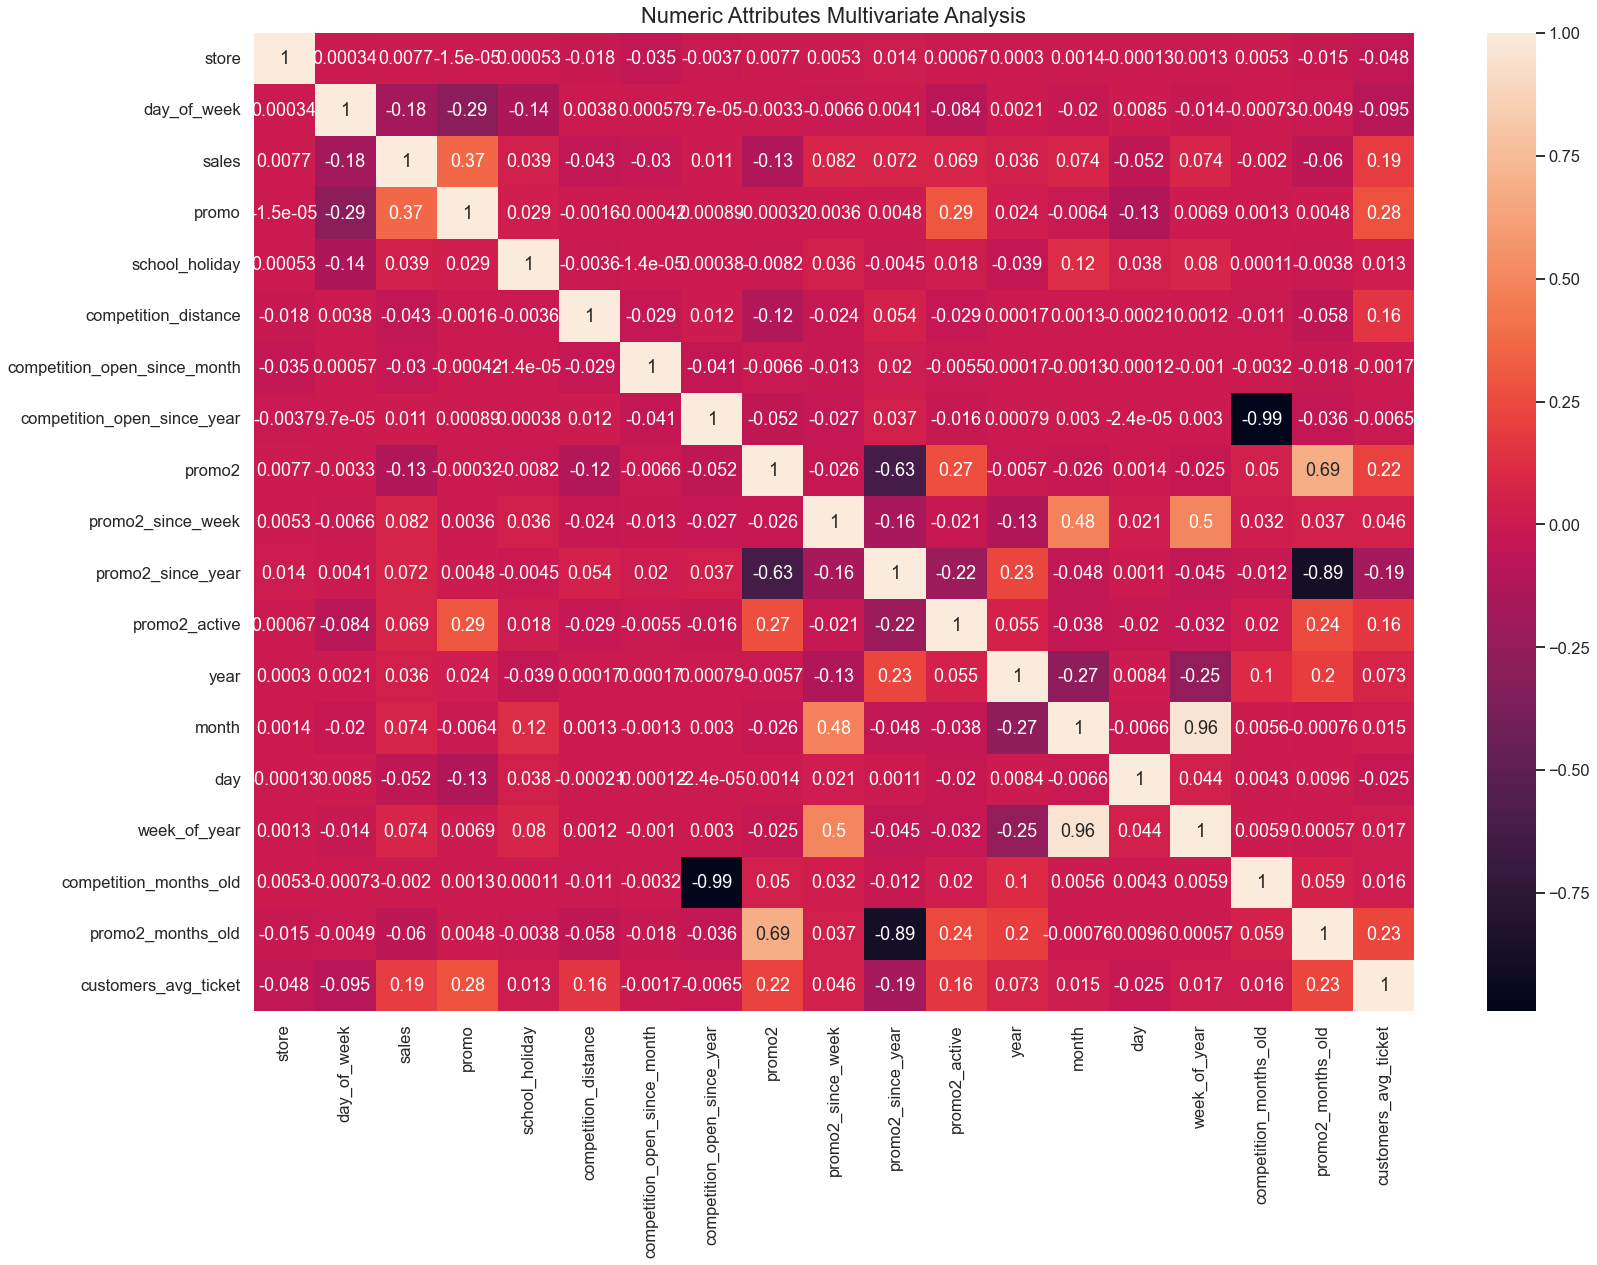

In [82]:
correlation = df_numeric.corr(method='pearson')

plt.figure(figsize=(26,18))
plt.title('Numeric Attributes Multivariate Analysis', fontsize=22, pad=10)
sns.heatmap(correlation, annot=True)

# plt.savefig('../img/multivar_analysis/numeric_attributes_multivar_analysis.png')
plt.show()

### <font color='#2365FF'> 4.3.2. Categorical Attributes </font>

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [83]:
# calculating Cramér's V 

a1 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['state_holiday'])
a2 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['store_type'])
a3 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['assortment'])
a4 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['promo'])
a5 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['promo2'])
a6 = cramer_v(df_cat_n_bin['state_holiday'], df_cat_n_bin['school_holiday'])

b1 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['state_holiday'])
b2 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['store_type'])
b3 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['assortment'])
b4 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['promo'])
b5 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['promo2'])
b6 = cramer_v(df_cat_n_bin['store_type'], df_cat_n_bin['school_holiday'])

c1 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['state_holiday'])
c2 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['store_type'])
c3 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['assortment'])
c4 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['promo'])
c5 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['promo2'])
c6 = cramer_v(df_cat_n_bin['assortment'], df_cat_n_bin['school_holiday'])

d1 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['state_holiday'])
d2 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['store_type'])
d3 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['assortment'])
d4 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['promo'])
d5 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['promo2'])
d6 = cramer_v(df_cat_n_bin['promo'], df_cat_n_bin['school_holiday'])

e1 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['state_holiday'])
e2 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['store_type'])
e3 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['assortment'])
e4 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['promo'])
e5 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['promo2'])
e6 = cramer_v(df_cat_n_bin['promo2'], df_cat_n_bin['school_holiday'])

f1 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['state_holiday'])
f2 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['store_type'])
f3 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['assortment'])
f4 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['promo'])
f5 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['promo2'])
f6 = cramer_v(df_cat_n_bin['school_holiday'], df_cat_n_bin['school_holiday'])

# creating dataframe with Cramer's V results
df_cramer_v = pd.DataFrame({'state_holiday': [a1, a2, a3, a4, a5, a6], 
                            'store_type': [b1, b2, b3, b4, b5, b6], 
                            'assortment': [c1, c2, c3, c4, c5, c6], 
                            'promo': [d1, d2, d3, d4, d5, d6], 
                            'promo2': [e1, e2, e3, e4, e5, e6], 
                            'school_holiday': [f1, f2, f3, f4, f5, f6]})
# using columns names to set the indexes names
df_cramer_v.set_index(keys=df_cramer_v.columns, drop=False, inplace=True)

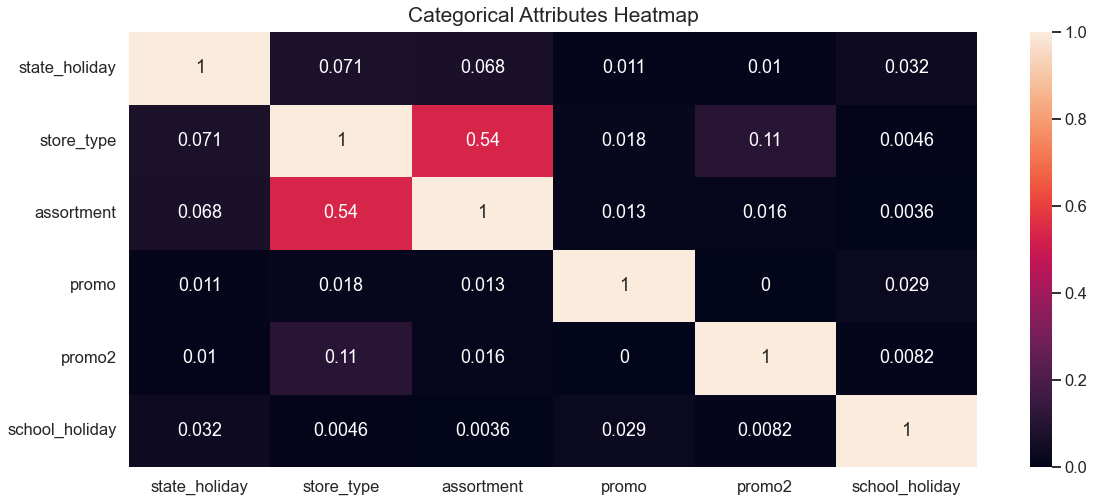

In [84]:
# heatmap

plt.figure(figsize=(19, 8))
plt.title('Categorical Attributes Heatmap', fontsize=21, pad=10)
sns.heatmap(df_cramer_v, annot=True)
# plt.savefig('../img/multivar_analysis/categorical_attributes_multivar_analysis.png')
plt.show()

# <font color='#3F0094'> 5. Data Preparation </font>

## <font color='#200CF'> 5.0. Dataframe in Progress Backup </font>

In [28]:
# dataframe copy
df5 = df4.copy()

## <font color='#200CF'> 5.1. Feature Scaling - Standardization </font>

**Also called Z-score normalization. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance).**

<font color='firebrick'>**None of the features behavior is close to a Gaussian (normal) distribution, so standardization is not recommended.**</font>

## <font color='#200CF'> 5.2. Feature Scaling - Normalization </font>

**Normalization typically means rescales the values into a range of [0, 1] .**

**ROBUST SCALER**

Its use is indicated for cases where data have outliers. To overcome this, the median and interquartile range can be used to rescale numeric variables.

In [29]:
# rescaling with Robust Scaler
rs = RobustScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_months_old
df5['competition_months_old'] = rs.fit_transform(df5[['competition_months_old']].values)

**MIN-MAX SCALER**

In [30]:
# rescaling with Min-Max Scaler
mms = MinMaxScaler()

# promo2_months_old
df5['promo2_months_old'] = mms.fit_transform(df5[['promo2_months_old']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## <font color='#200CF'> 5.3. Feature Transformation </font>

### <font color='#2365FF'> 5.3.1. Encoding </font>

**Enconding: Transforming Categorical Features Into Numeric Features**

**ONE HOT ENCODING -- ORDINAL ENCODING -- SMOOTHED MEAN ENCODING**

In [31]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['st_hol'], columns=['state_holiday'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 0.1, 
                   'extended': 0.2, 
                   'extra': 0.3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

# store_type - Smoothed Mean Encoding
sales_mean = df5['sales'].mean()
agg = df5[['store_type', 'sales']].groupby('store_type').agg(['count', 'mean'])
counts = agg.loc[:, ('sales', 'count')]
means = agg.loc[:, ('sales', 'mean')]
weight = 10000
smooth = ((counts*means + weight*sales_mean) / (counts + weight))/10000
df5['store_type'] = df5['store_type'].map(smooth)

### <font color='#2365FF'> 5.3.2. Nature Transformation </font>

In [32]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))
# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

### <font color='#2365FF'> 5.3.3. Response Variable Tranformation - Log Transform </font>

In [33]:
df5['sales'] = np.log1p(df5['sales'])

# <font color='#3F0094'> 6. Feature Selection </font>

## <font color='#200CF'> 6.0. Dataframe in Progress Backup </font>

In [34]:
df6 = df5.copy()

## <font color='#200CF'> 6.1. Dataframe Split into Training and Test Dataset </font>

In [ ]:
# droping irrelevant and variables that were derived
cols_drop = ['customers_avg_ticket', 'month', 'day', 'week_of_year', 'year_week', 'day_of_week']
df6.drop(labels=cols_drop, axis=1, inplace=True)

In [ ]:
# selecting the last 6 weeks as test dataset and all previous dates as train dataset
X_train = df6[df6['date'] < '2015-01-01']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-01-01']
y_test = X_test['sales']

## <font color='#200CF'> 6.2. Boruta as Feature Selector </font>

In [ ]:
# train and test dataset for boruta
X_train_n = X_train.drop(labels=['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# defining RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# defining BorutaPy
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### <font color='#2365FF'> 6.2.1. Best Features from Boruta </font>

In [ ]:
# all features except date and sales
X_train_fs = X_train.head(1).drop(['date', 'sales'], axis=1)

# features selected by boruta
cols_selected = boruta.support_.tolist()
cols_selected_names = X_train_fs.iloc[:, cols_selected].columns.tolist()
print(f"List of columns selected by Boruta:\n{', '.join(cols_selected_names)}.")

# features not selected by boruta
cols_rejected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_names))
print(f"\nList of columns rejected by Boruta:\n{', '.join(cols_rejected_boruta)}.")

## <font color='#200CF'> 6.3. Feature Selection - Final Decision </font>

In [ ]:
# using boruta feature selection + adding month_sin
selected_features = [
    'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
    'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_months_old',
    'promo2_months_old', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos']

# inserting 'date' and 'sales' back to the features list
selected_features.extend(['date', 'sales'])

# <font color='#3F0094'> 7. Machine Learning </font>

## <font color='#200CF'> 7.0. Dataframe Backup and Train/Test Split</font>

In [92]:
# selected features in the previous stage
selected_features = [
    'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
    'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_months_old',
    'promo2_months_old', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 
    'date', 'sales']
# dataframe backup using selected features
df7 = df6[selected_features].copy()

# train/test split
# selecting the last 6 weeks as test dataset and all previous dates as train dataset
X_train = df7[df7['date'] < '2015-01-01']
y_train = X_train['sales']
X_test = df7[df7['date'] >= '2015-01-01']
y_test = X_test['sales']

# WARNING: Remember to drop 'date' and 'sales' columns from X_train and X_test before running models
X_train_ml = X_train.drop(labels=['date', 'sales'], axis=1)
X_test_ml = X_test.drop(labels=['date', 'sales'], axis=1)

## <font color='#200CF'> 7.1. Average Model </font>

In [93]:
# for this model it is fine to use date and sales from X_train and X_test
# using store and sales columns to compare actual values and predicted (average) values
aux1 = X_test[['store', 'sales']]

# using X_train dataset to calculate the average sales for each store
aux2 = X_train[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = aux1.reset_index().merge(aux2, how='left', on='store', validate='many_to_one').set_index('index')
aux1 = aux1.merge(aux2, how='left', on='store', validate='many_to_one')
yhat_baseline = aux1['predictions']

# performance test
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1435.166505,0.213648,1940.458462


## <font color='#200CF'> 7.2. Linear Regression Model </font>

In [94]:
# model
lr = LinearRegression().fit(X_train_ml, y_train)

# prediction
yhat_lr = lr.predict(X_test_ml)

# performance test
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1938.050756,0.314943,2670.070911


## <font color='#200CF'> 7.3. Linear Regression Regularized (Lasso) Model </font>

In [95]:
# model
lrr = Lasso(alpha=0.001).fit(X_train_ml, y_train)

# prediction
yhat_lrr = lrr.predict(X_test_ml)

# performance test
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1923.455701,0.299454,2724.244482


## <font color='#200CF'> 7.4. Random Forest Regressor </font>

In [96]:
# model
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42).fit(X_train_ml, y_train)

# prediction
yhat_rf = rf.predict(X_test_ml)

# performance test
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,832.517079,0.120696,1284.094774


## <font color='#200CF'> 7.5. XGBoost Regressor </font>

In [101]:
# model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=200, 
                             eta=0.1, 
                             max_depth=10, 
                             subsample=0.7, 
                             colsample_bytree=0.9).fit(X_train_ml, y_train)

# prediction
yhat_xgb = xgb_model.predict(X_test_ml)

# performance test
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,903.175315,0.128265,1304.700745


## <font color='#200CF'> 7.6. Comparison of Models Performance  </font>

In [107]:
single_performance = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
single_performance.sort_values(by='RMSE', inplace=True)
# single_performance.to_csv('../ml_models_performances/single_performance.csv', index=False)
single_performance.reset_index(drop=True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,832.517079,0.120696,1284.094774
1,XGBoost Regressor,903.175315,0.128265,1304.700745
2,Average Model,1435.166505,0.213648,1940.458462
3,Linear Regression,1938.050756,0.314943,2670.070911
4,Linear Regression - Lasso,1923.455701,0.299454,2724.244482


## <font color='#200CF'> 7.7. Cross-Validation </font>

### <font color='#2365FF'> 7.7.1. Linear Regression - Cross Validation </font>

In [81]:
model = LinearRegression()
lr_result_cv = cross_validation(X_train, kfold=8, model_name='Linear Regression', ml_model=model, verbose=False)

### <font color='#2365FF'> 7.7.2. Linear Regression Regularized (Lasso) - Cross Validation </font>

In [85]:
model = Lasso(alpha=0.001)
lasso_result_cv = cross_validation(X_train, kfold=8, model_name='Lasso', ml_model=model, verbose=False)

### <font color='#2365FF'> 7.7.3. Random Forest Regressor - Cross Validation </font>

In [87]:
model = RandomForestRegressor(n_estimators=200, 
                              n_jobs=-1, 
                              random_state=42).fit(X_train_ml, y_train)
rf_result_cv = cross_validation(X_train, kfold=8, model_name='Random Forest Regressor', ml_model=model, verbose=True)


KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


### <font color='#2365FF'> 7.7.4. XGBoost Regressor - Cross Validation </font>

In [89]:
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=200, 
                         eta=0.1, 
                         max_depth=10, 
                         subsample=0.7, 
                         colsample_bytree=0.9).fit(X_train_ml, y_train)
xgb_result_cv = cross_validation(X_train, kfold=8, model_name='XGBoost Regressor', ml_model=model, verbose=True)


KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


## <font color='#200CF'> 7.8. Comparison of Models Performance w/ Cross Validation </font>

In [99]:
cv_performance = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])
cv_performance.sort_values(by='RMSE CV', inplace=True)
# cv_performance.to_csv('../ml_models_performances/cross_validation_performance.csv', index=False)
cv_performance.reset_index(drop=True)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,772.42 +/- 204.31,0.11 +/- 0.02,1157.82 +/- 297.12
1,XGBoost Regressor,802.52 +/- 166.91,0.12 +/- 0.02,1167.5 +/- 237.3
2,Linear Regression,1995.08 +/- 219.4,0.32 +/- 0.02,2765.81 +/- 361.3
3,Lasso,1992.47 +/- 250.73,0.31 +/- 0.01,2825.92 +/- 392.19
